In [11]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import random
from tabulate import tabulate

# Texture factory creates 2D checkerboards with a transparecy placed on top.
from minimal_example_contrast_metric.texture_factory import TextureFactory

# fixed parameters for the texture factory
n = 21
image_width = 480
block_width = image_width // n

In [12]:
# luminance values are in random order, they are not ordered in an ascending or descending order

bg_luminance_values = [0.000001, 0.75, 0.25, 0.5, 1.0], [0.05, 0.725, 0.275, 0.5, 0.95], [0.1, 0.7, 0.3, 0.5, 0.9], [0.15, 0.675, 0.325, 0.5, 0.85], [0.2, 0.65, 0.35, 0.5, 0.8], [0.25, 0.625, 0.375, 0.5, 0.75], [0.3, 0.6, 0.4, 0.5, 0.7], [0.35, 0.575, 0.425, 0.5, 0.65], [0.4, 0.55, 0.45, 0.5, 0.6], [0.45,0.525,0.475,0.5,0.55] 
# 10 arrays of five luminance values, means there will be ten different backgrounds

tau_values = 0.1, 0.2, 0.5, 1.0
alpha_values = 0.1, 0.2, 0.5

images = []

for luminance in bg_luminance_values:
    f = TextureFactory('random',
                       block_width=block_width, 
                       image_width=image_width,
                       luminance_values=luminance)
    for tau in tau_values:
        for alpha in alpha_values:

            # here we ask the factory to give us different background contrasts with constant alpha and tau values.
            im = f.get_image(tau, alpha, bg_luminance=None)
            plt.figure()
            plt.imshow(im, cmap='gray', vmin=0, vmax=1)
            plt.close()

            # we need to convert array to PIL and use PIL library to save. MATPLOTLIB is not reliable when saving images
            # as it can add unwanted borders
            im = Image.fromarray(im*255).convert('L')
            # created images are added to images list
            images.append(im)

# we now have images with different background contrasts, tau and alpha values.

array size (480, 480)


array([0., 1.])

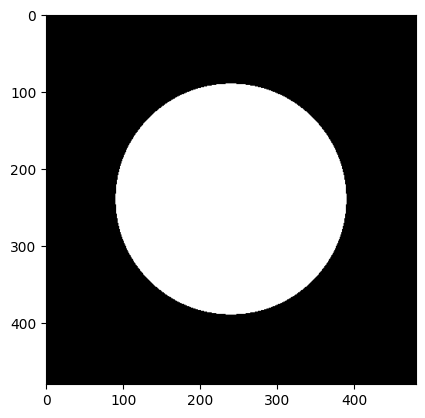

In [13]:
# creating the mask for the inner circle
# getting a checkerboard with a complete white opaque transparecy
f = TextureFactory('checkerboard',block_width=block_width, image_width=image_width,luminance_values= [0, 0, 0, 1, 1])
mask = f.get_image(1, 0, bg_luminance=0.0)

print('array size', mask.shape)
plt.figure()
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

# saving in case we need it in another notebook 
mask_im = Image.fromarray(mask*255).convert('L')
mask_im.save('mask.png')

np.unique(mask) # should be only 0 and 1 as the mask is binary

In [14]:
def to_array(i):
    
    # open images with a transparency
    ims = images[i]

    # convert to numpy array
    im = np.array(ims)
    display(Image.fromarray(im))     # uncomment if you want to see stimuli BEFORE mask is applied
    

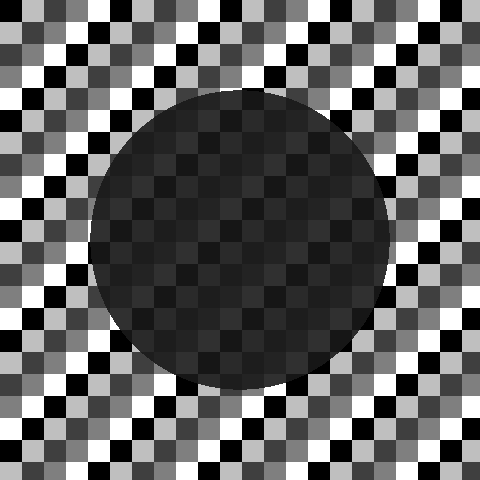

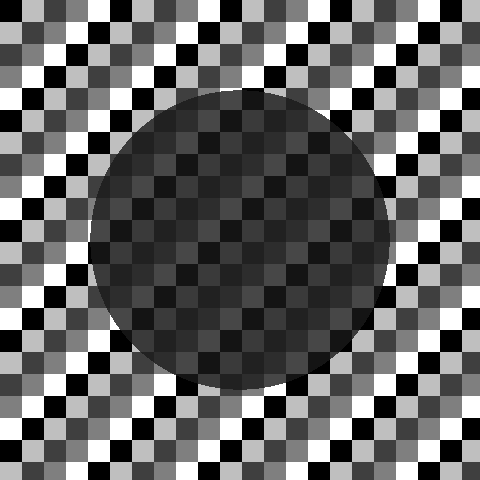

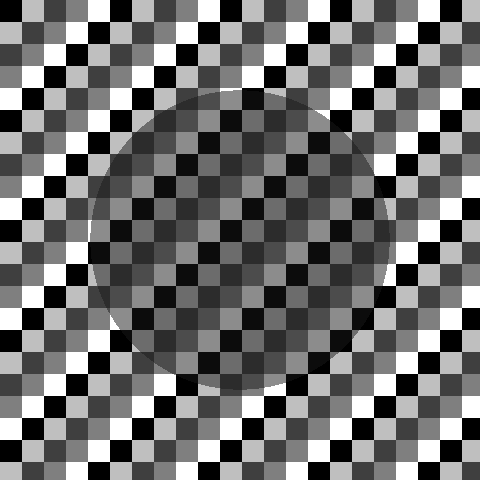

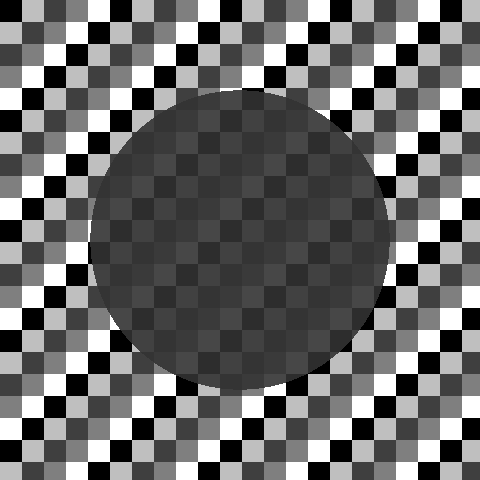

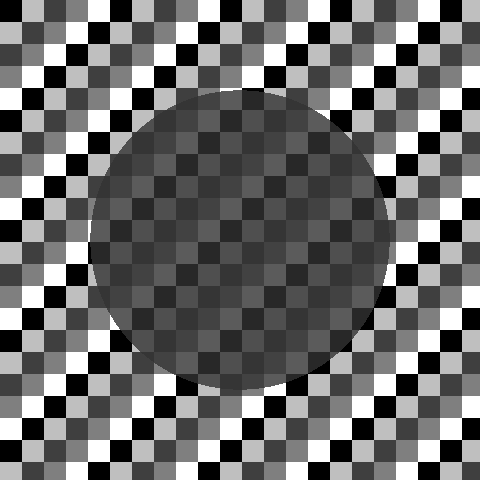

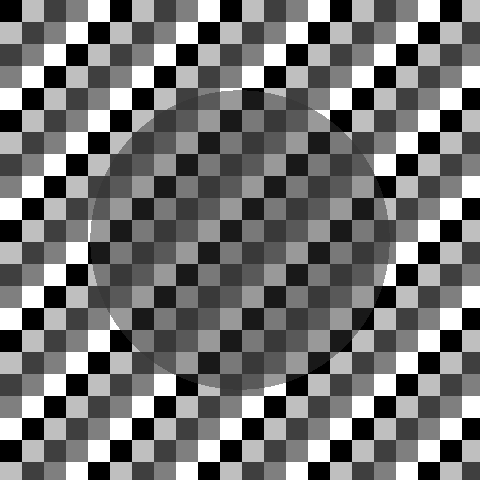

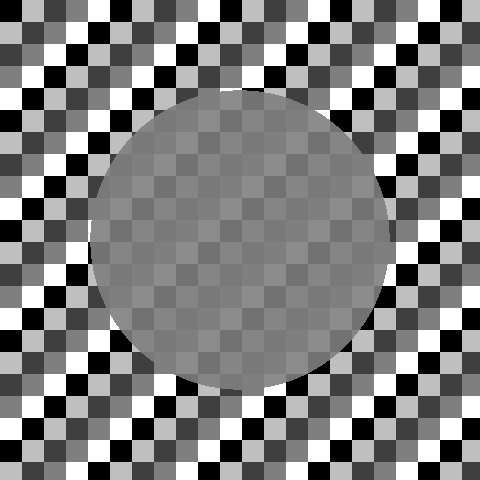

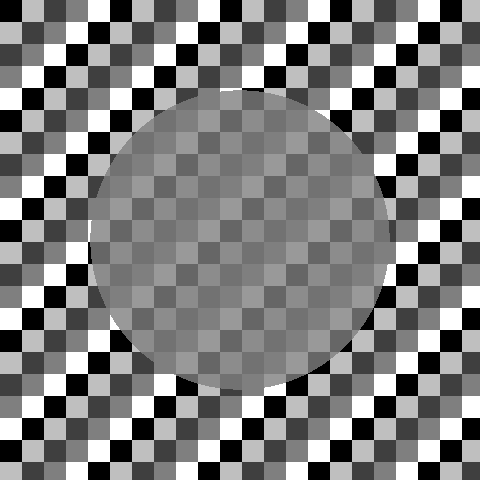

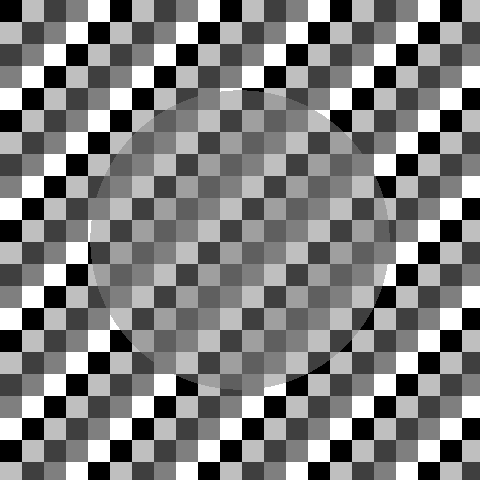

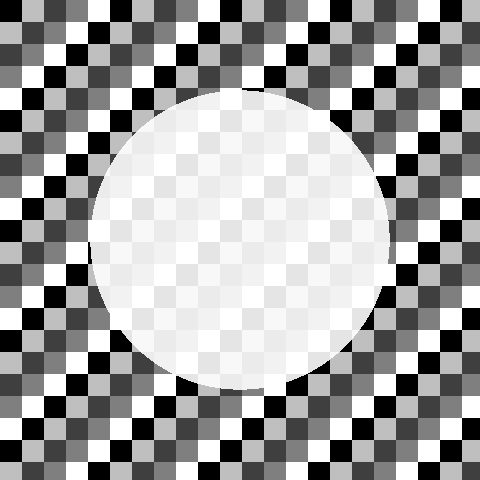

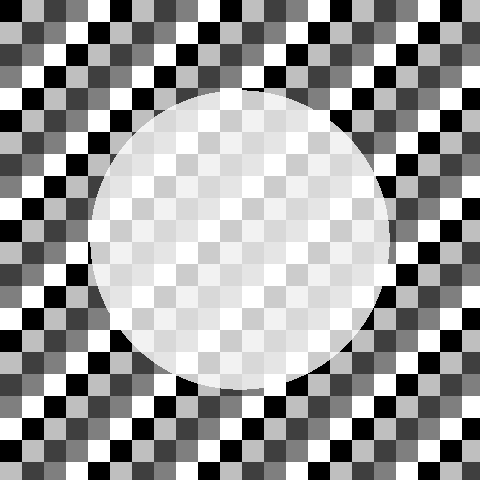

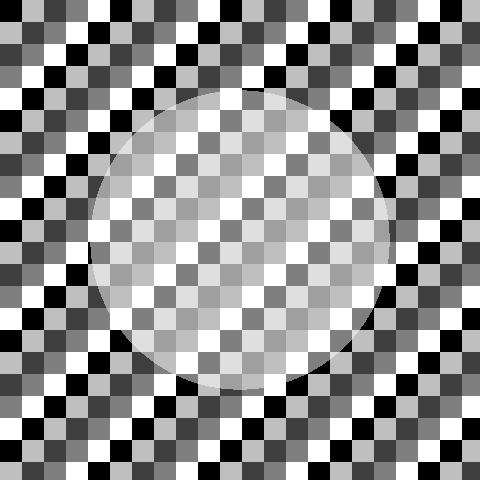

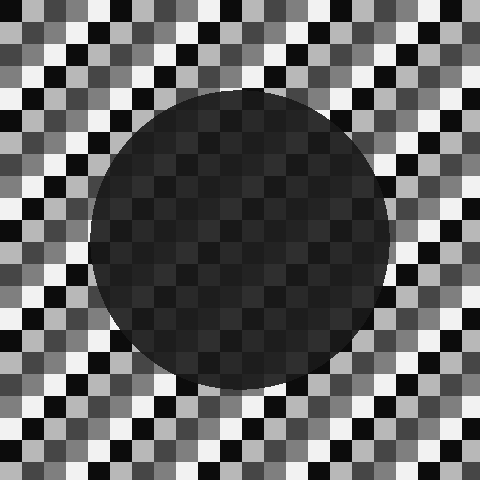

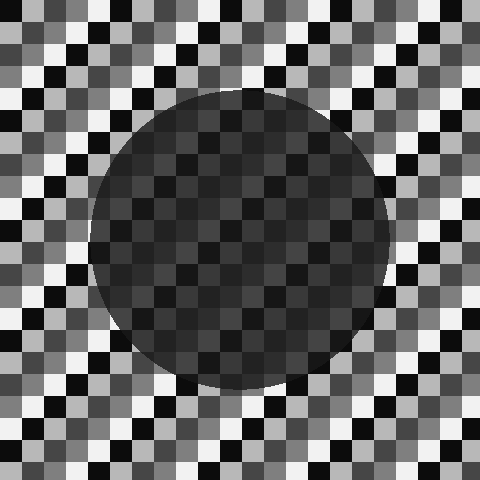

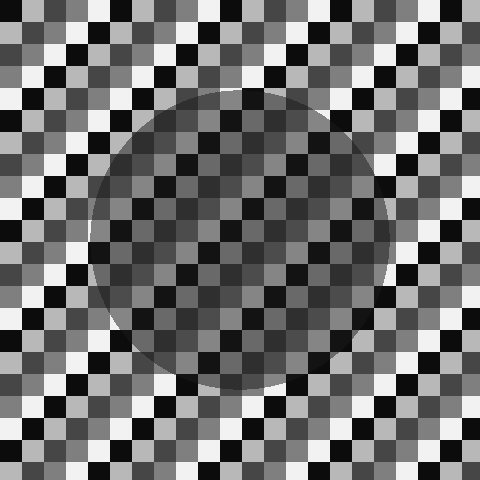

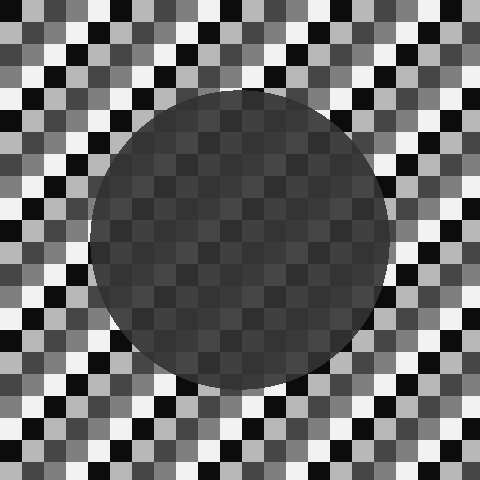

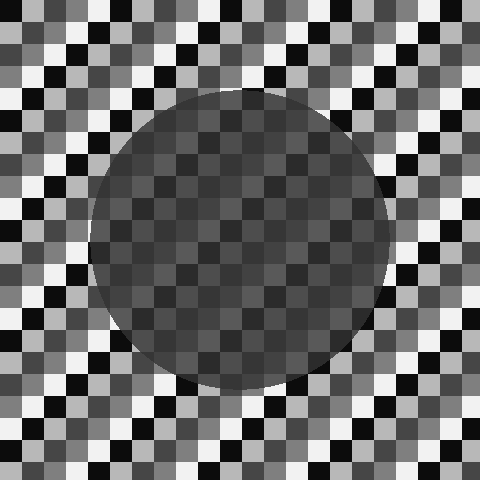

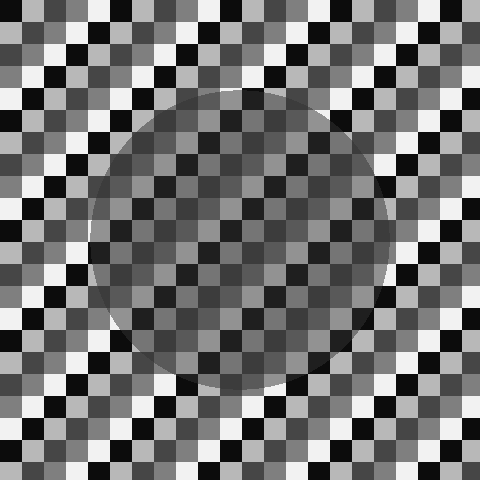

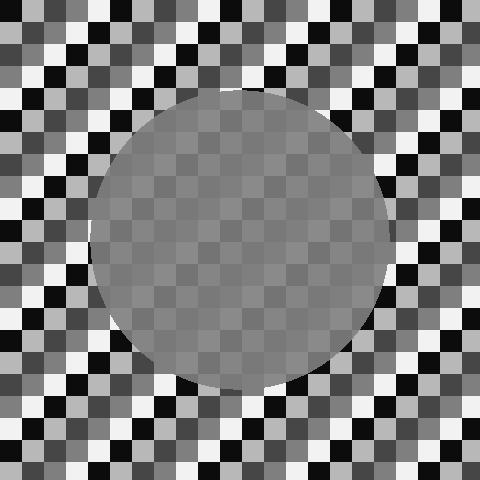

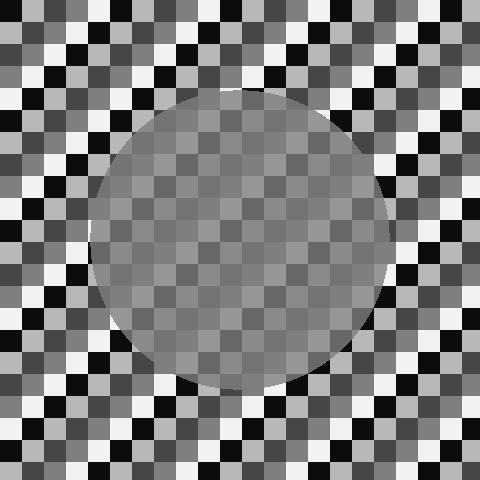

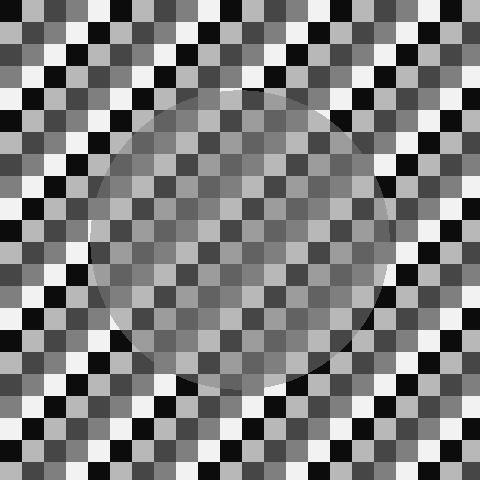

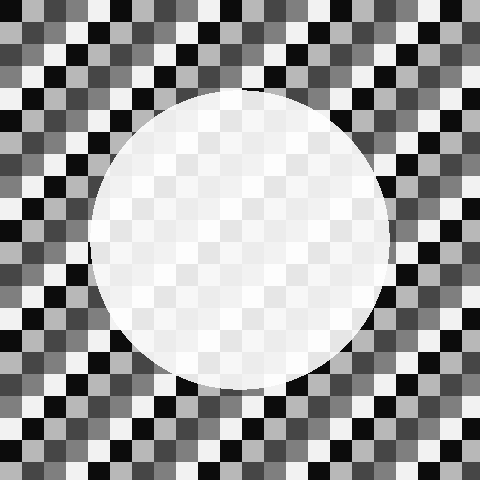

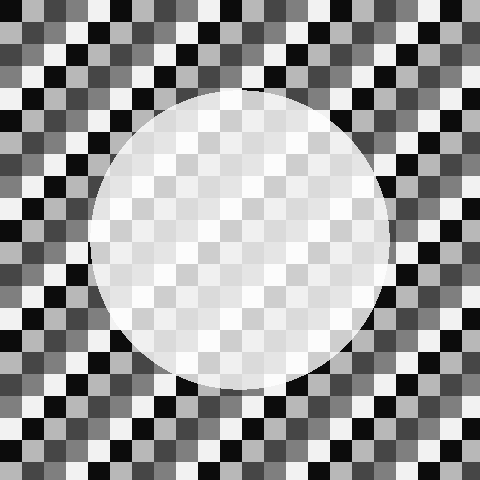

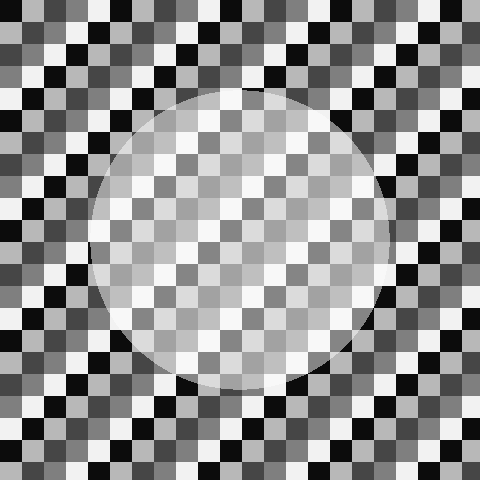

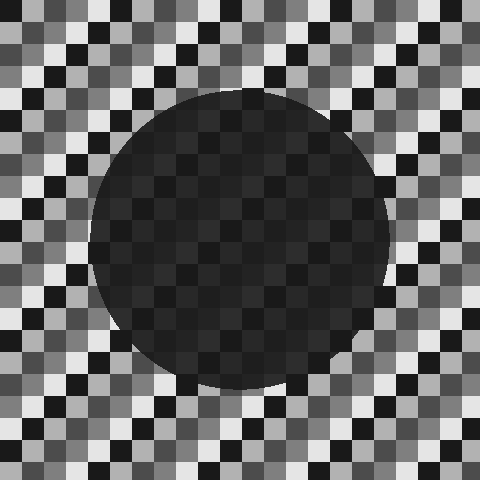

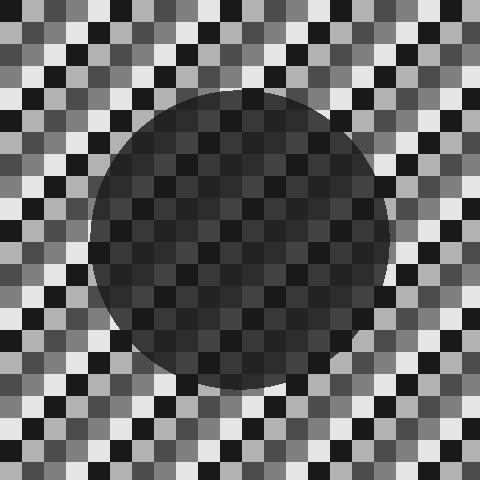

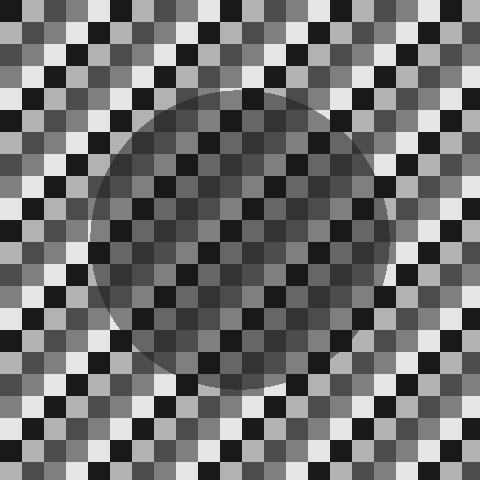

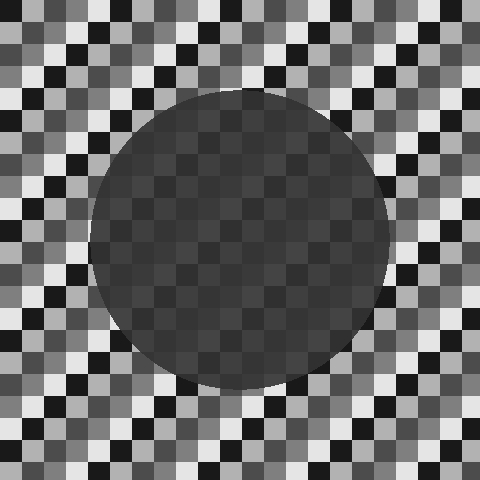

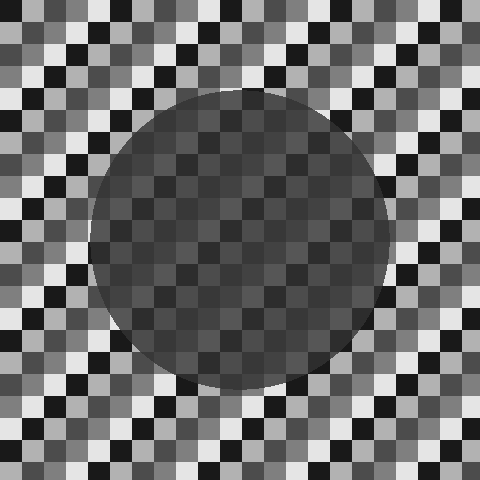

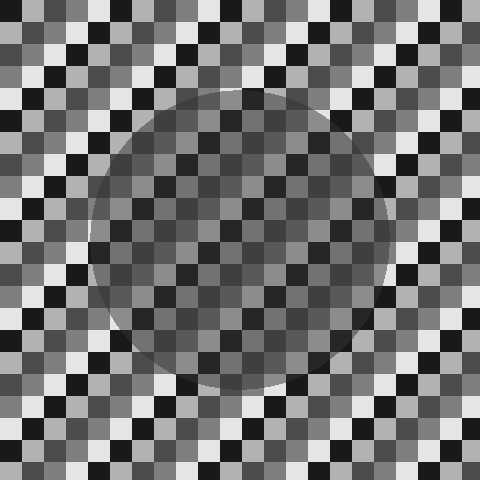

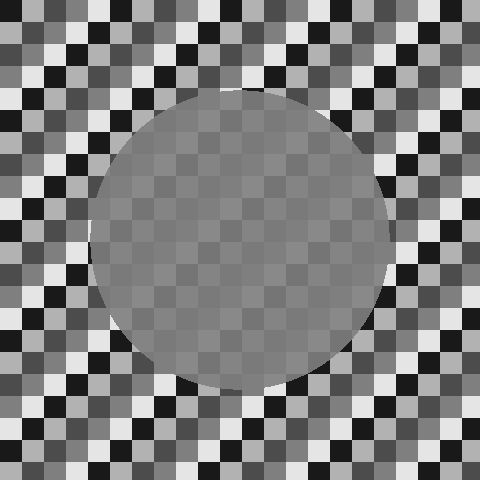

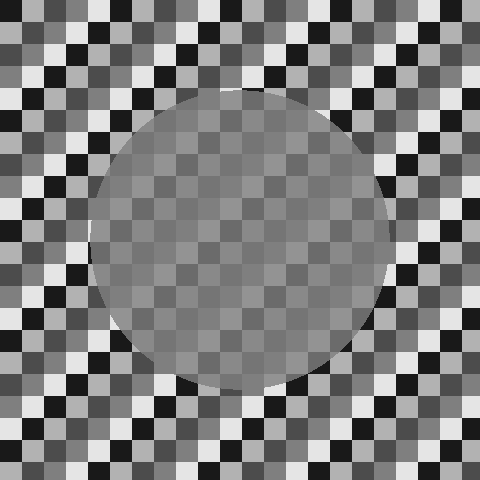

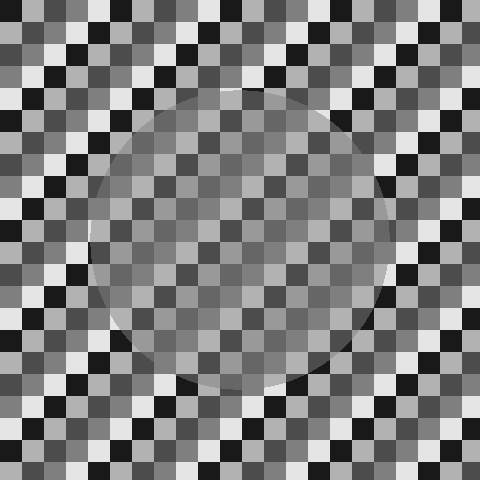

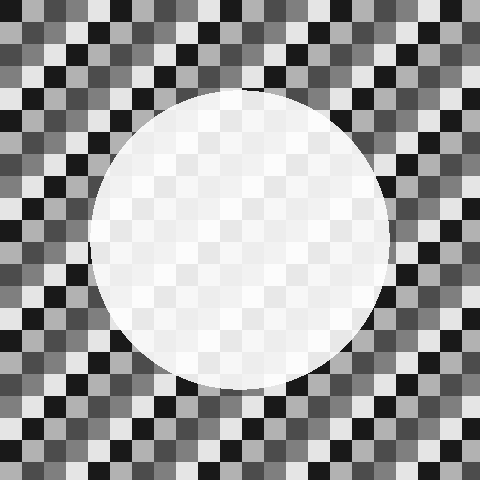

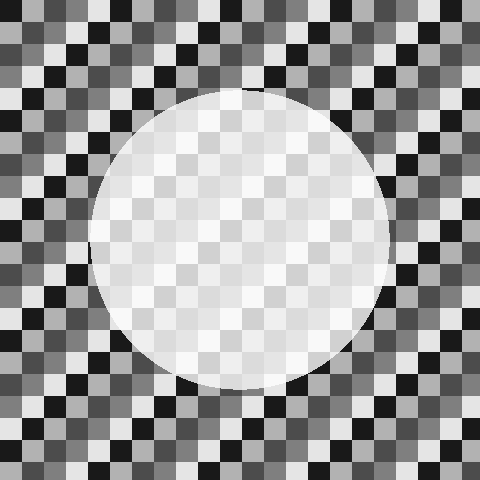

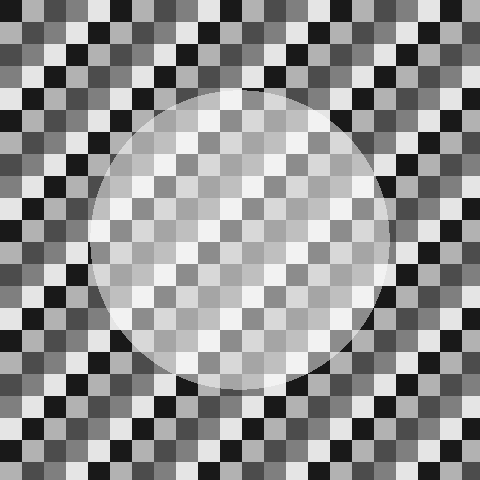

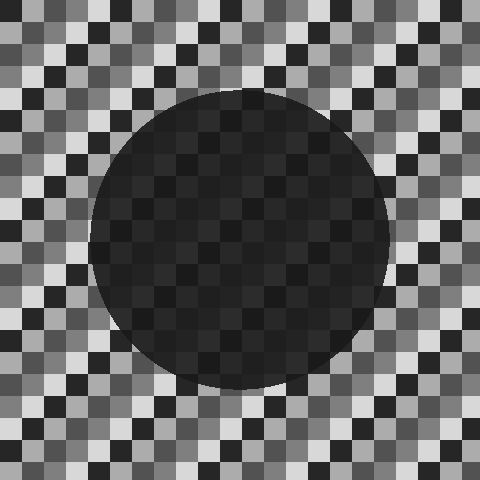

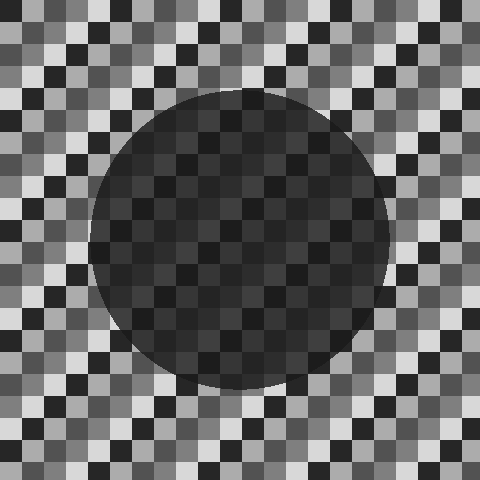

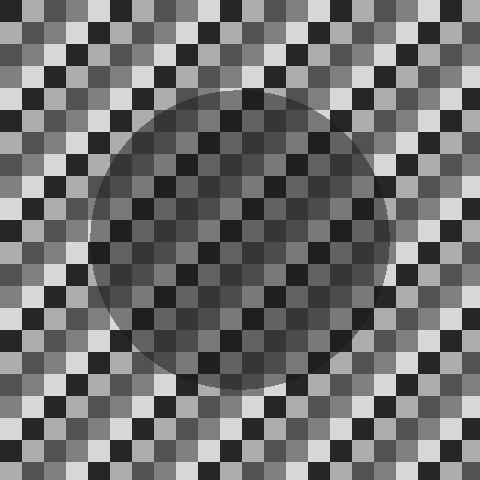

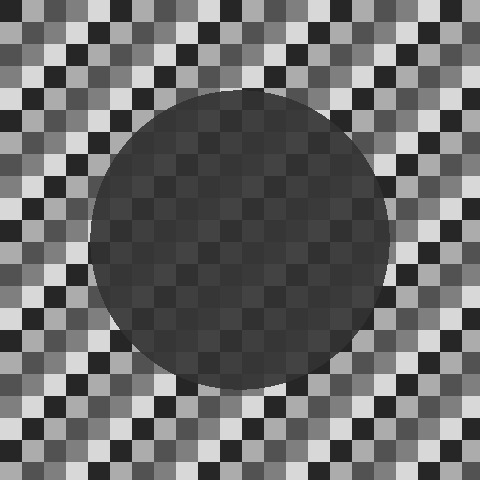

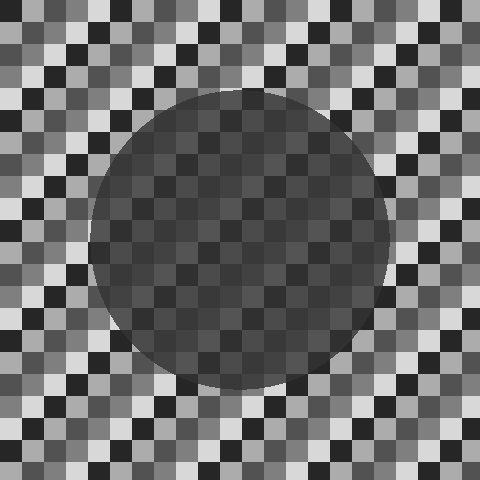

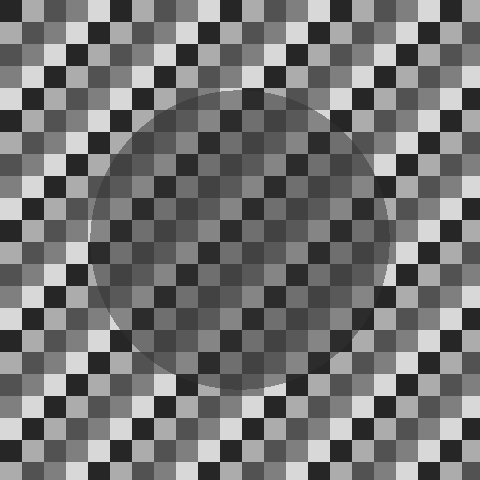

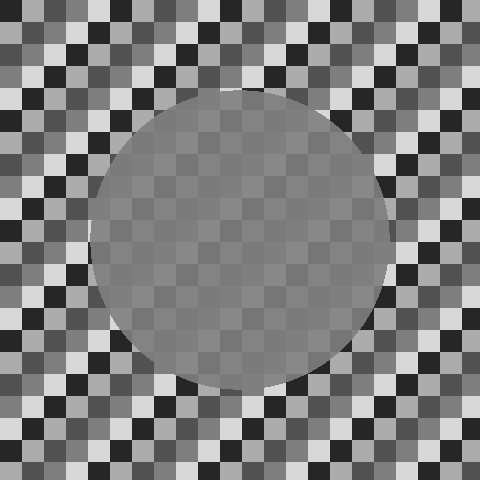

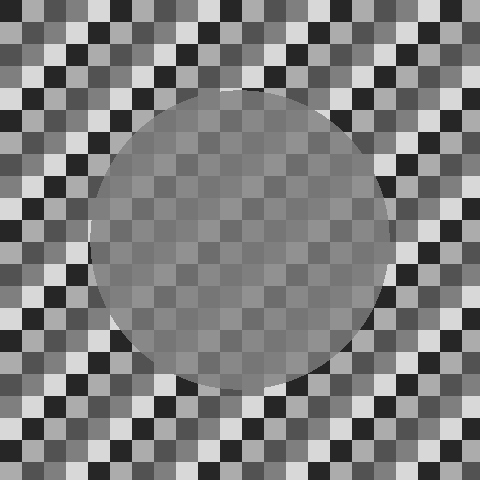

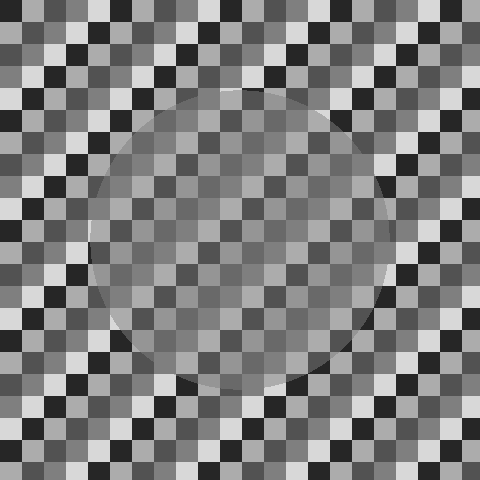

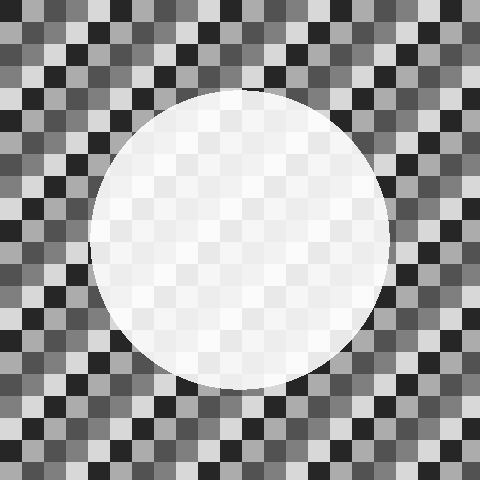

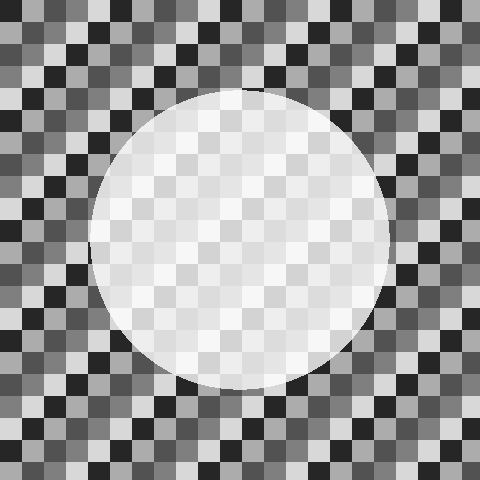

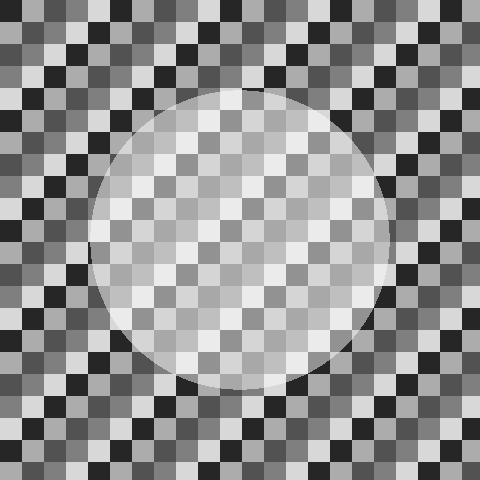

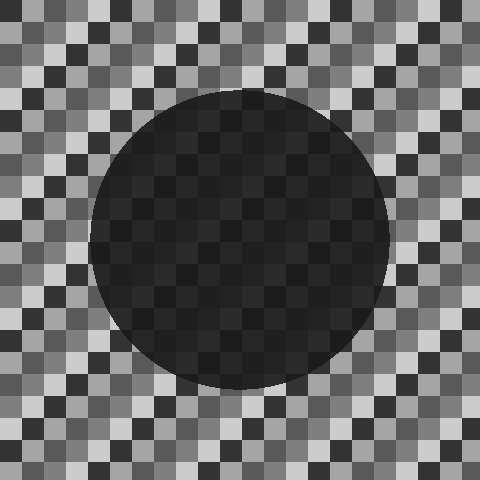

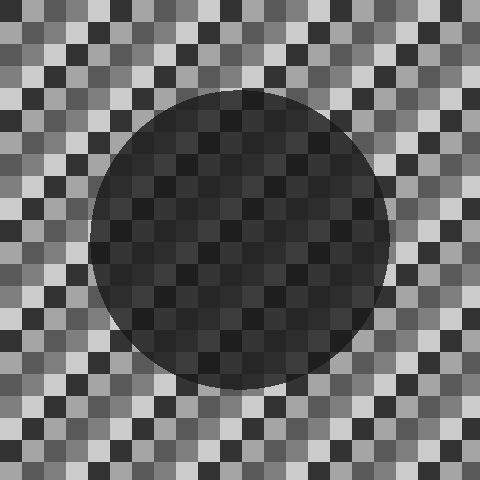

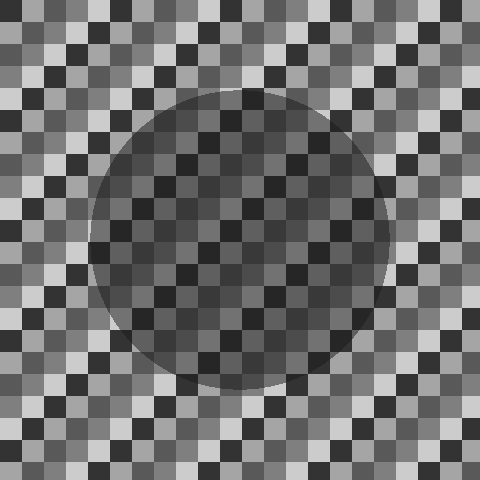

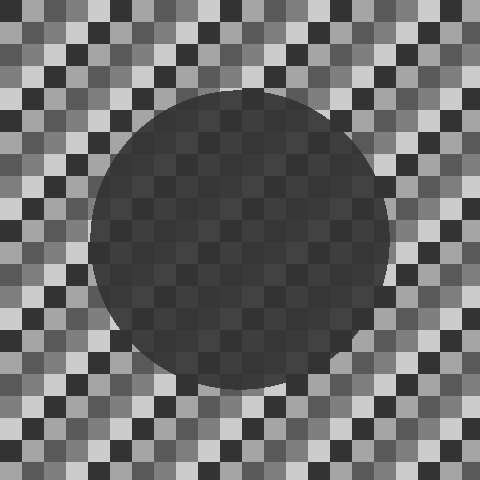

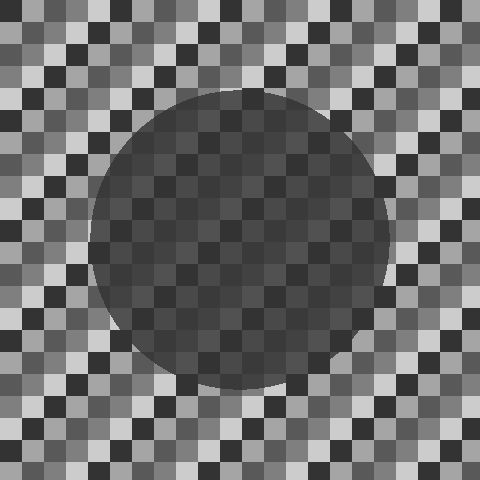

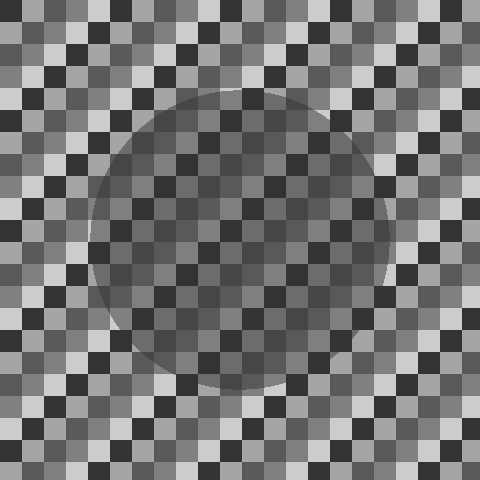

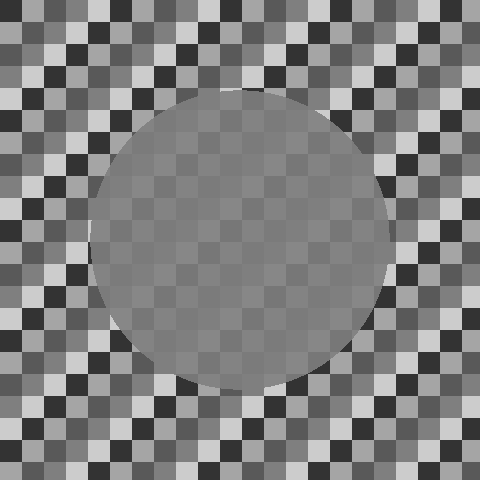

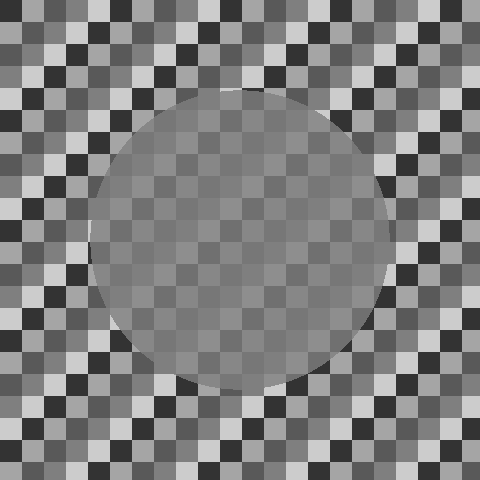

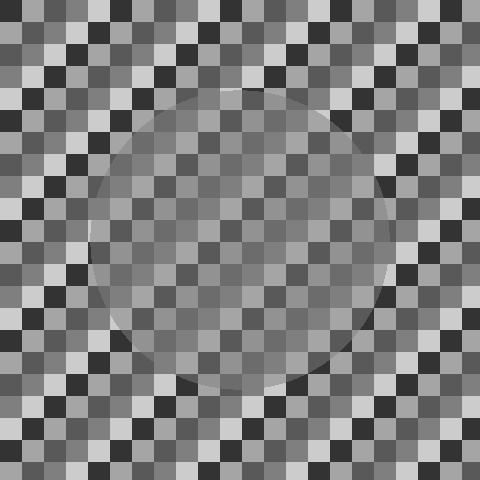

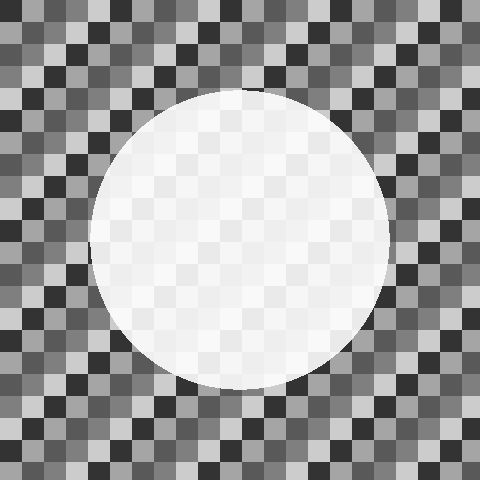

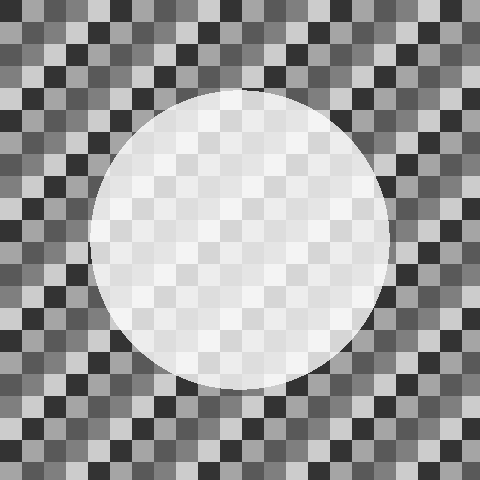

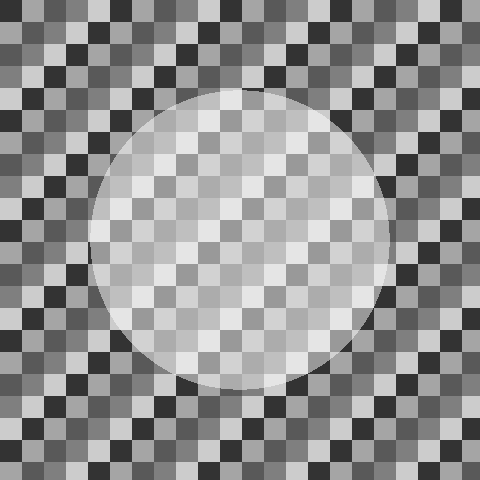

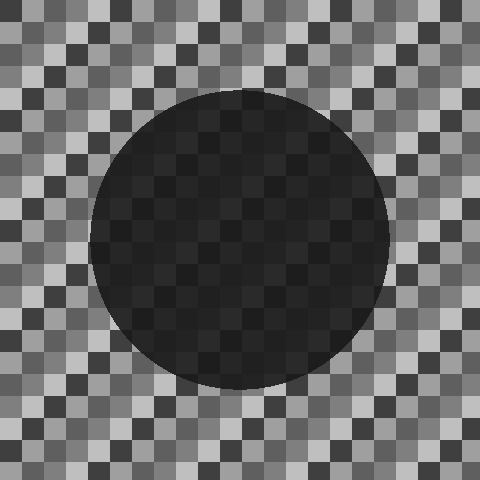

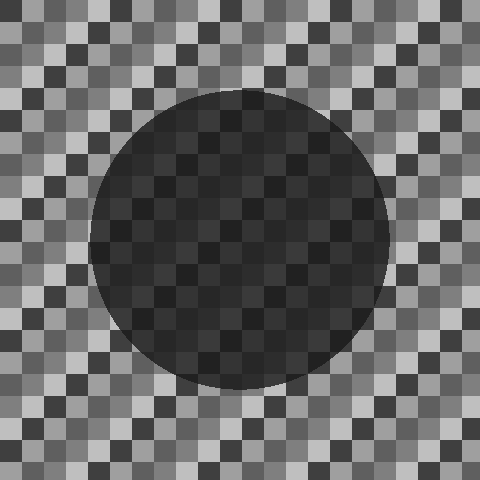

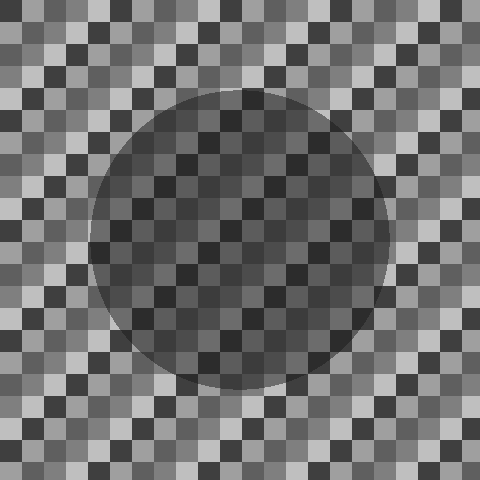

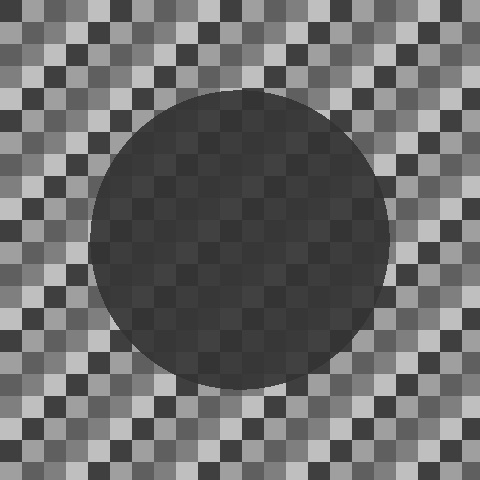

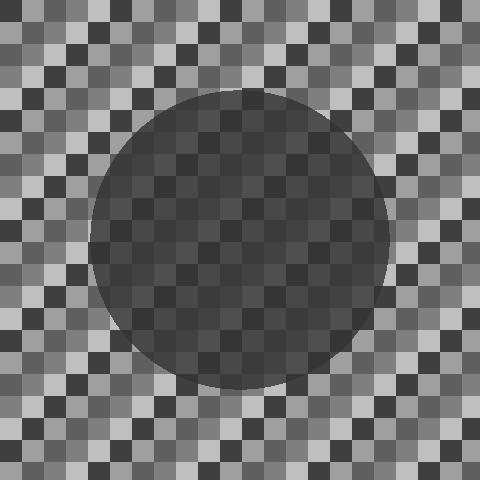

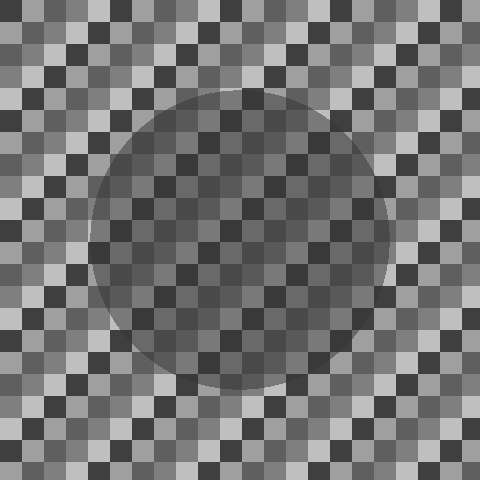

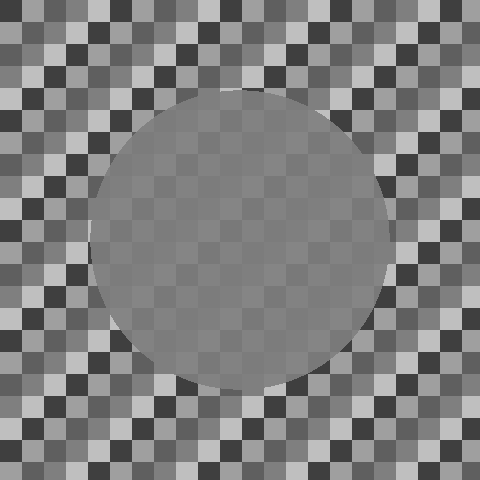

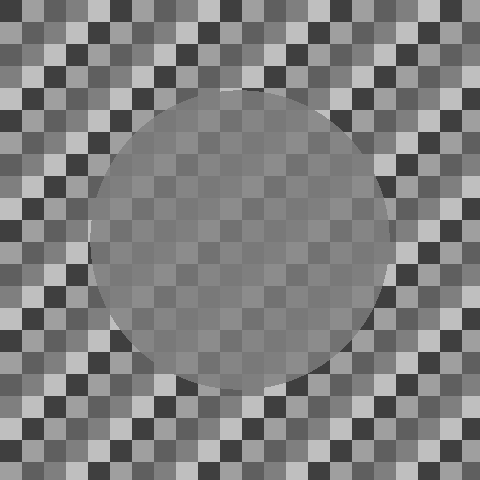

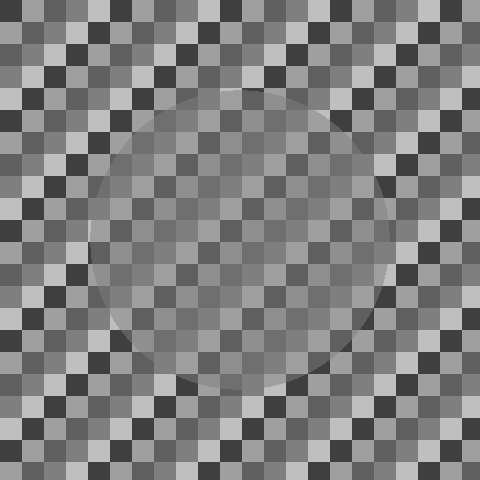

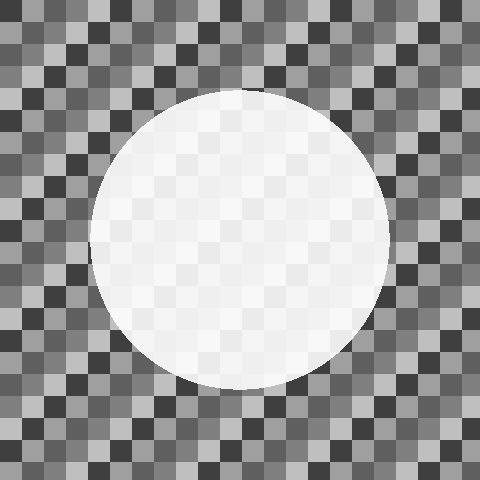

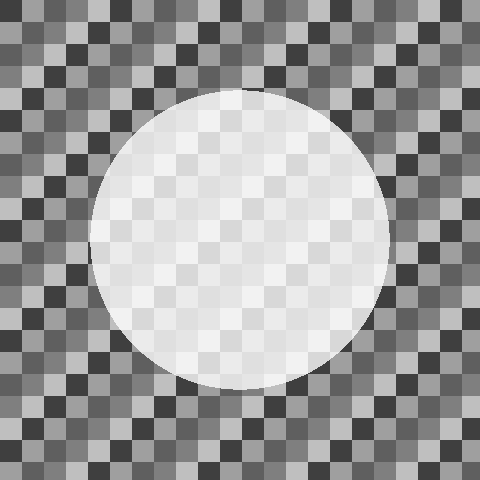

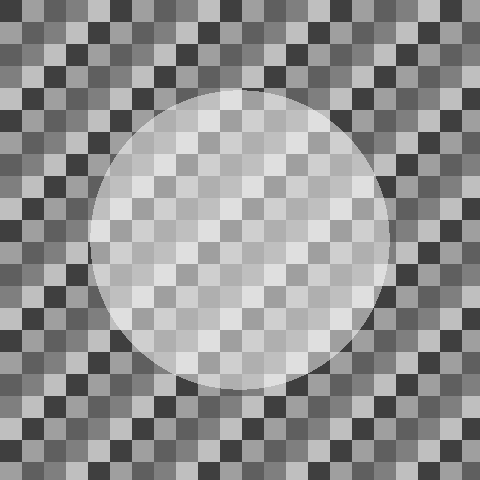

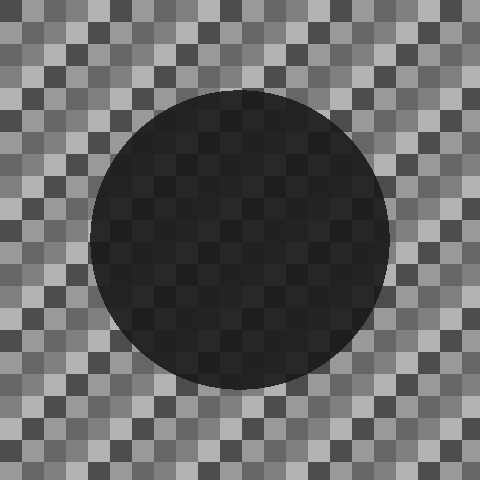

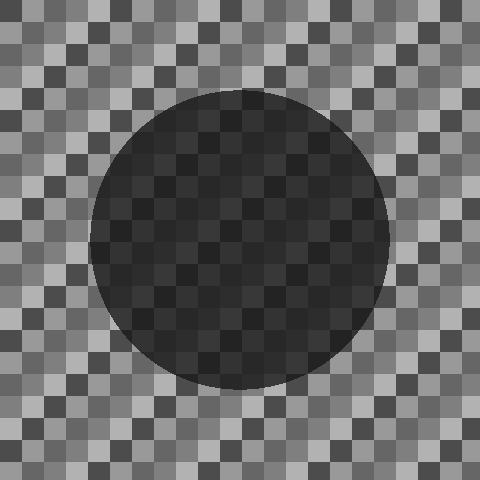

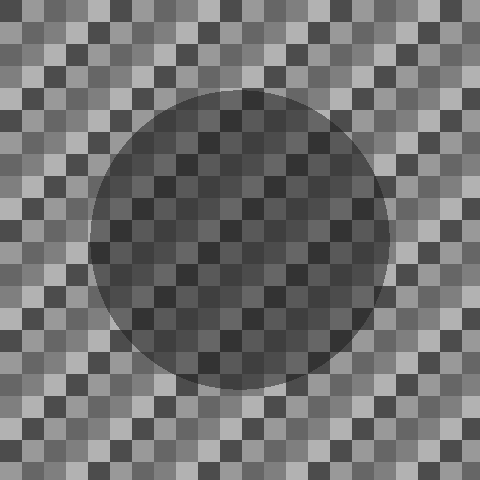

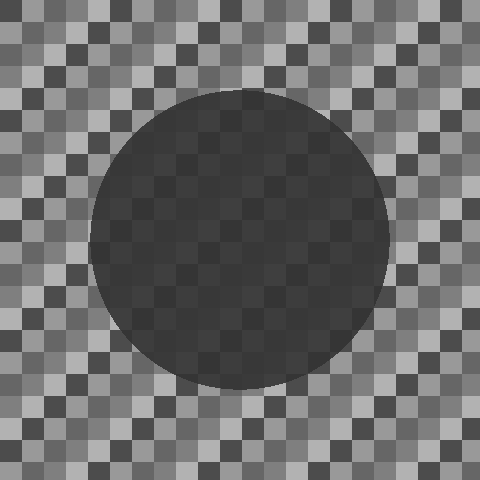

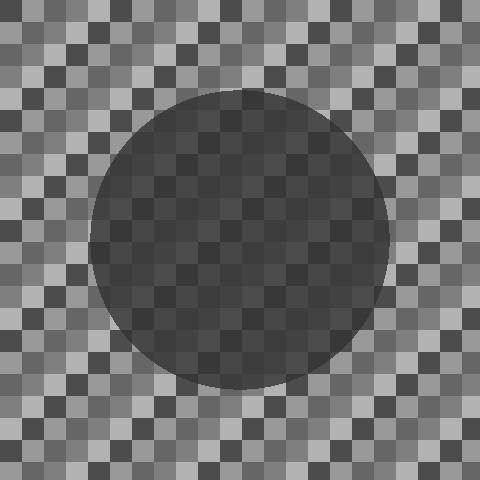

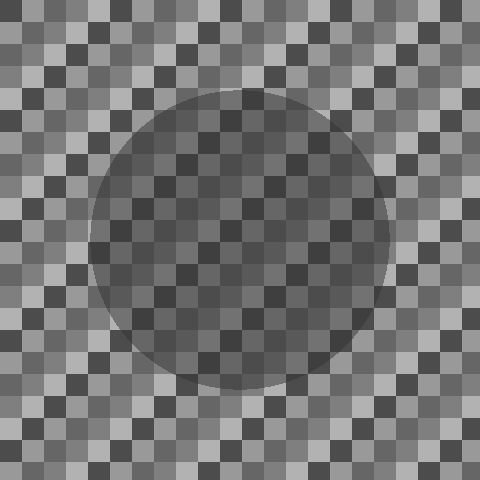

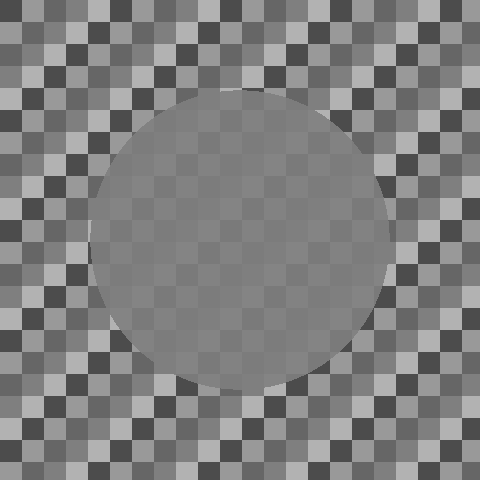

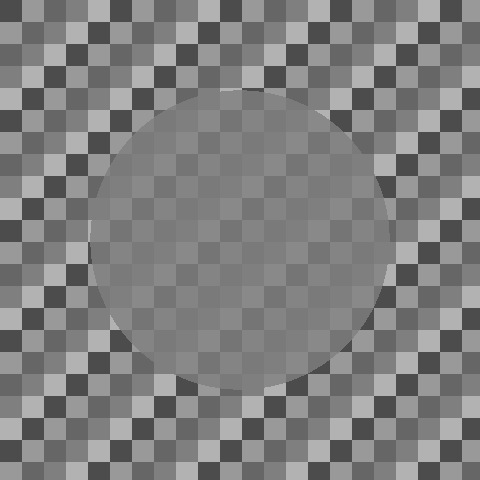

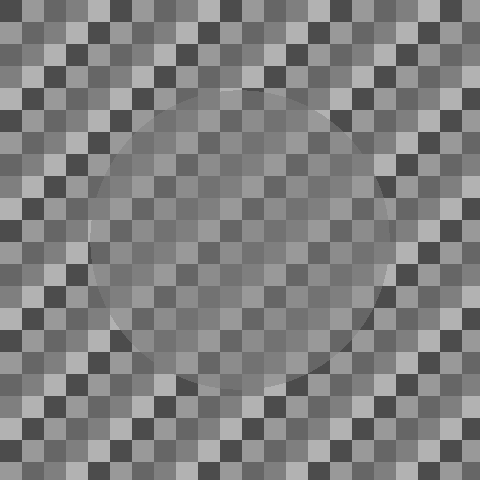

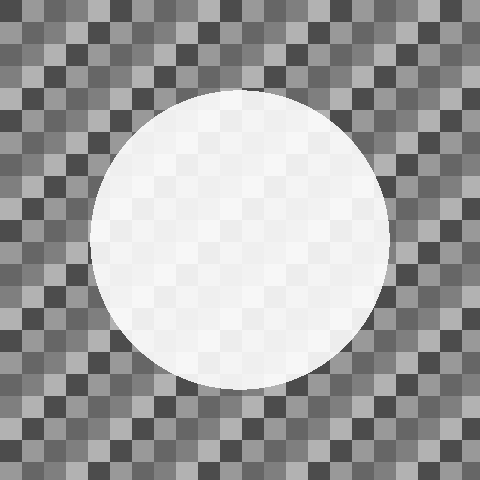

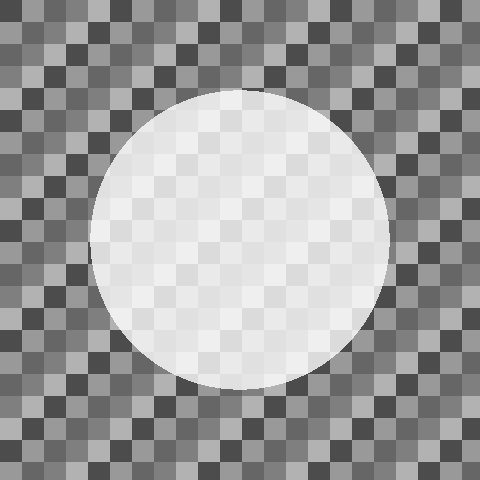

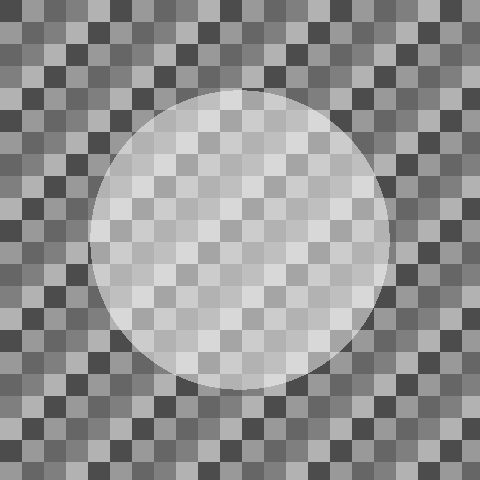

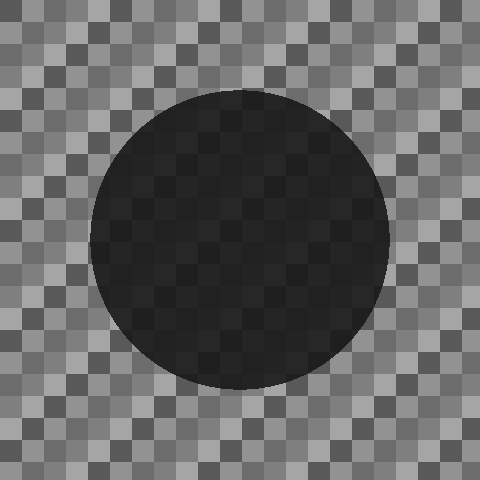

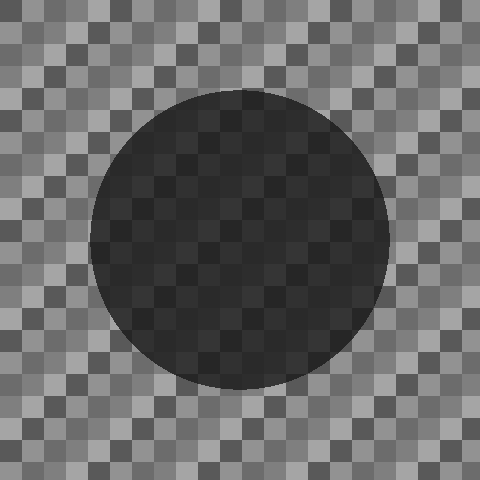

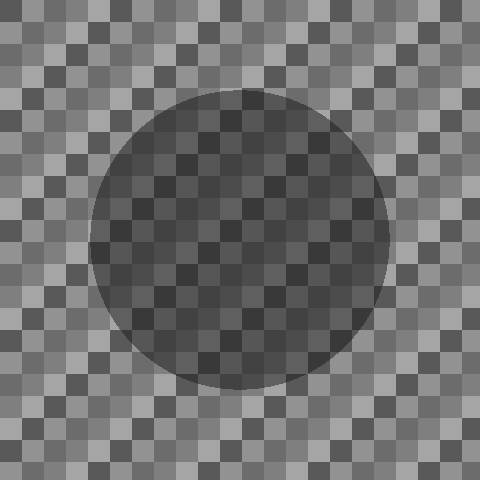

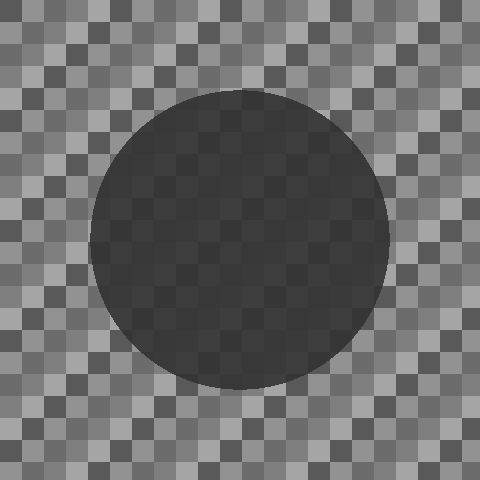

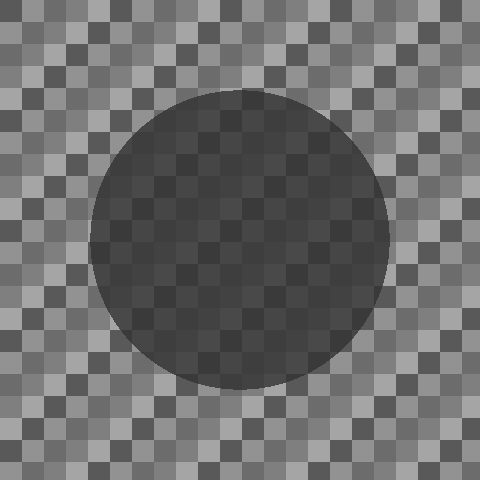

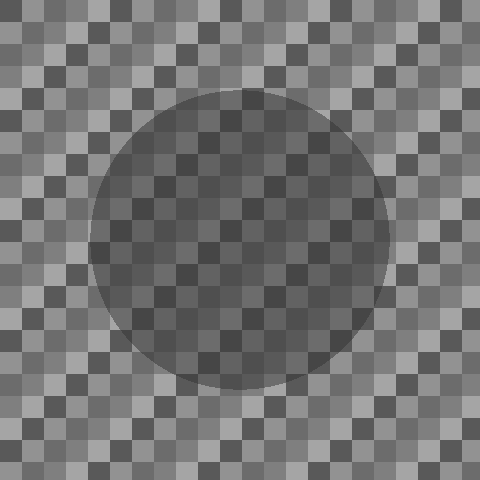

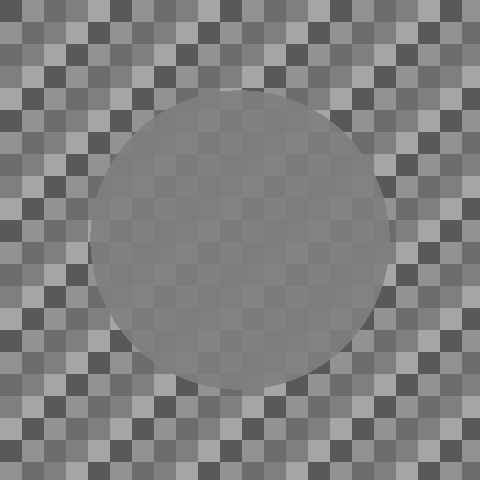

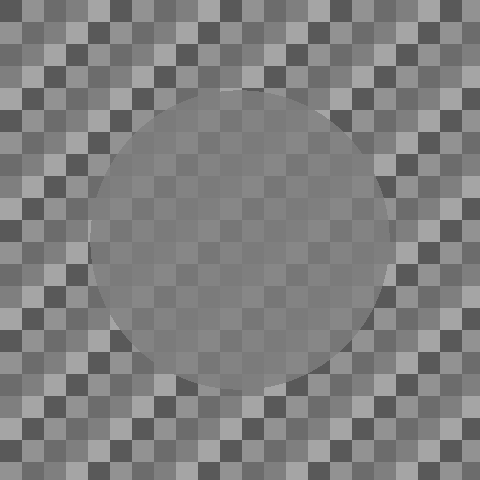

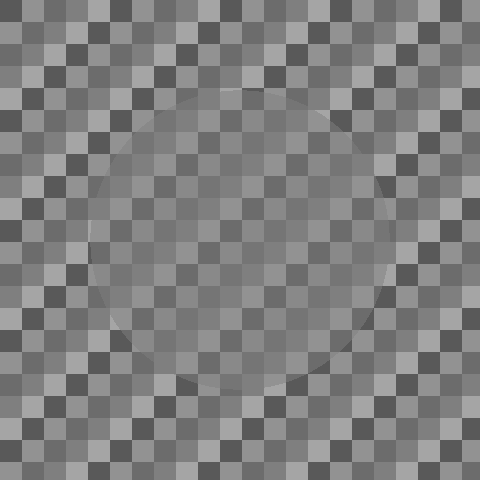

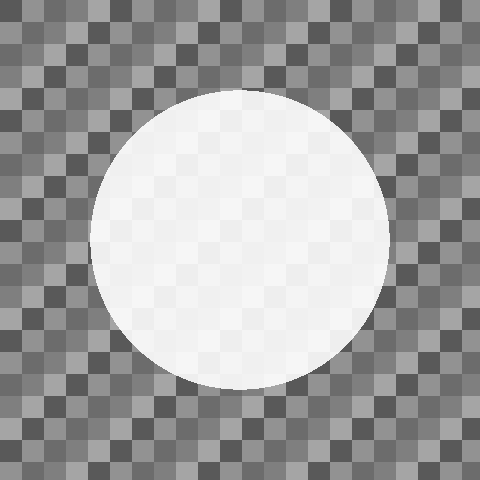

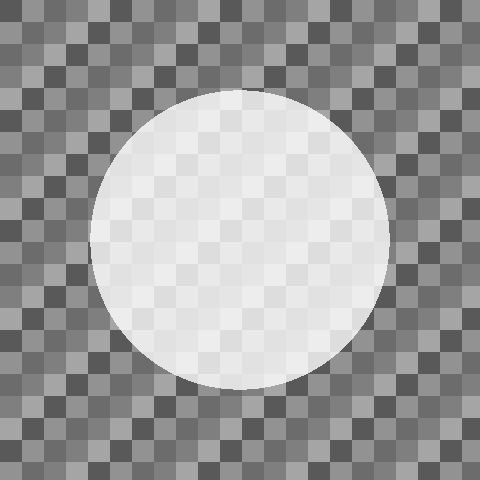

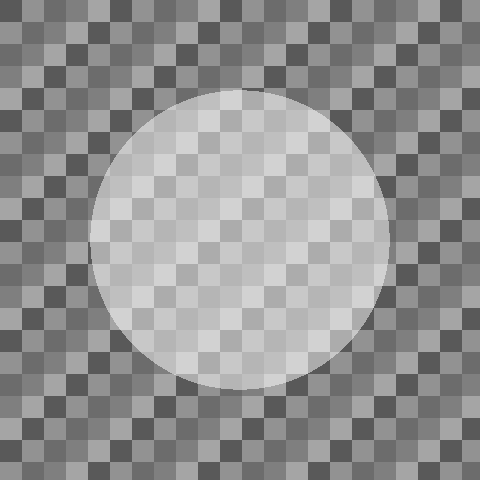

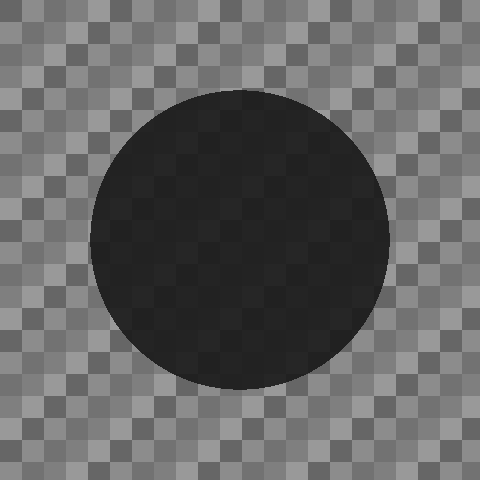

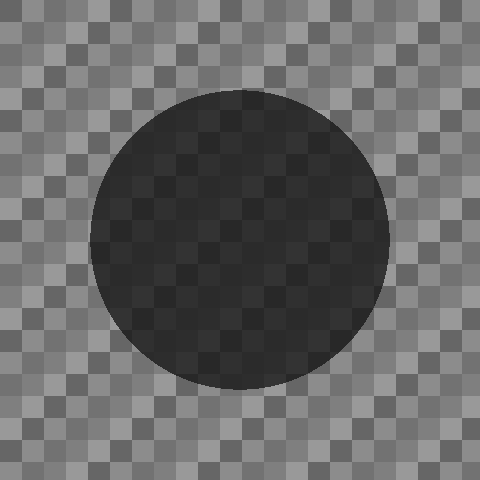

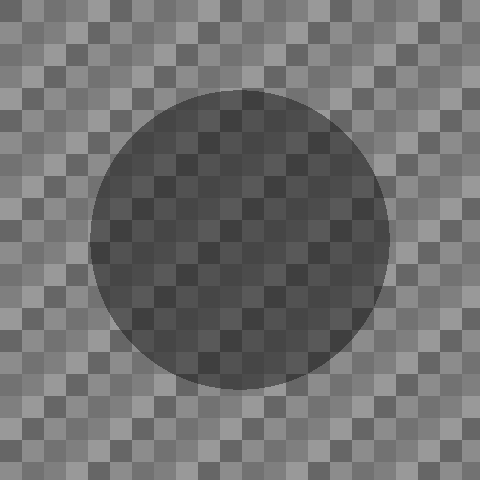

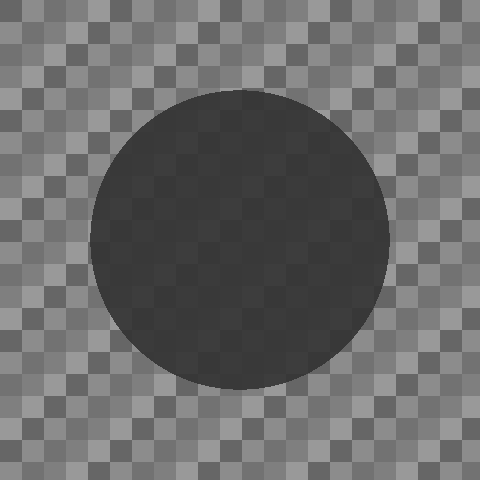

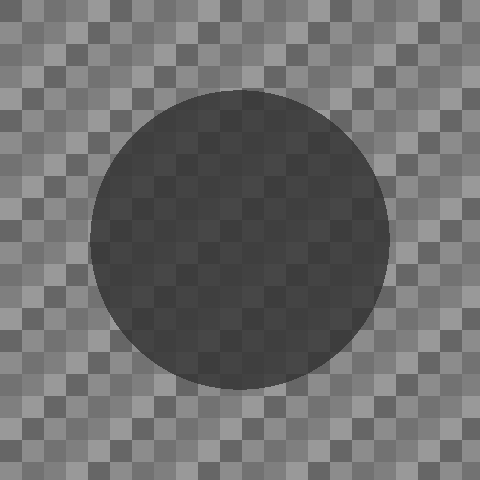

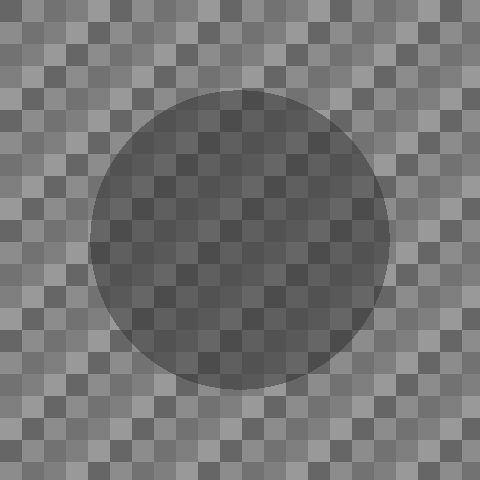

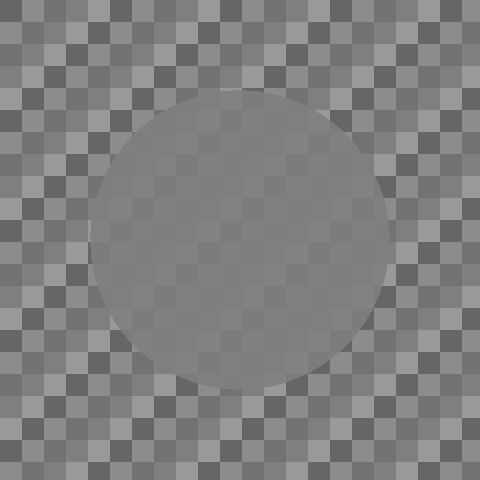

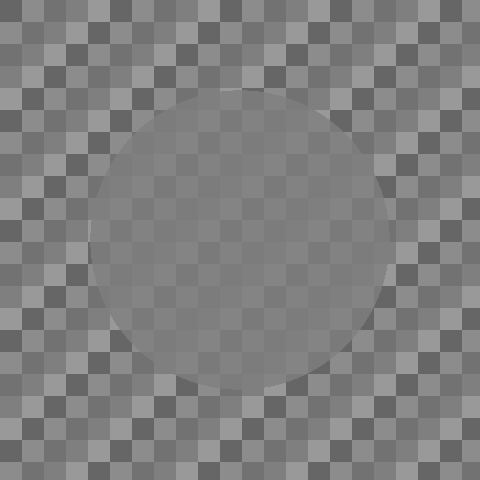

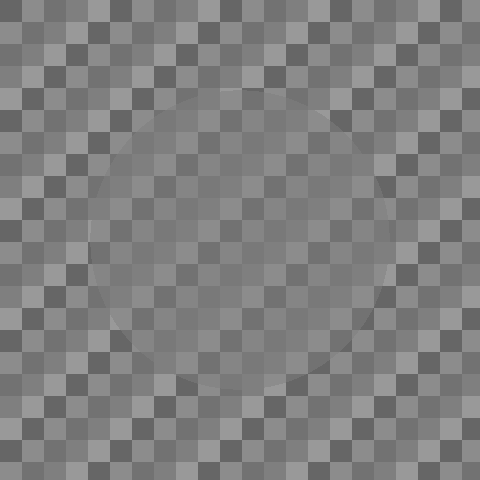

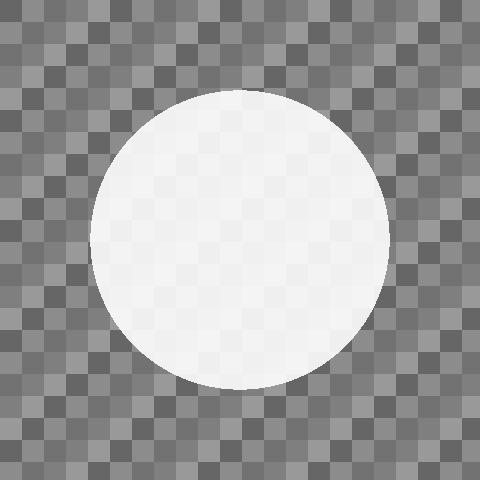

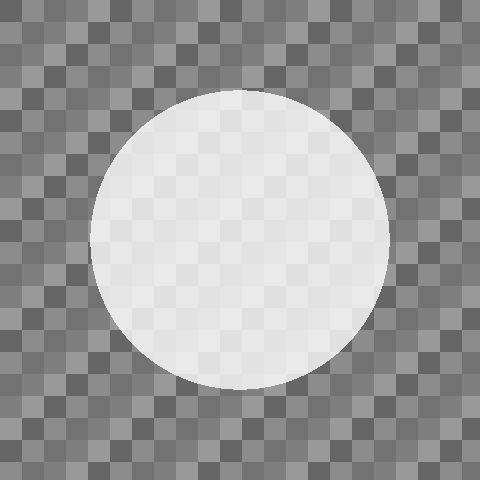

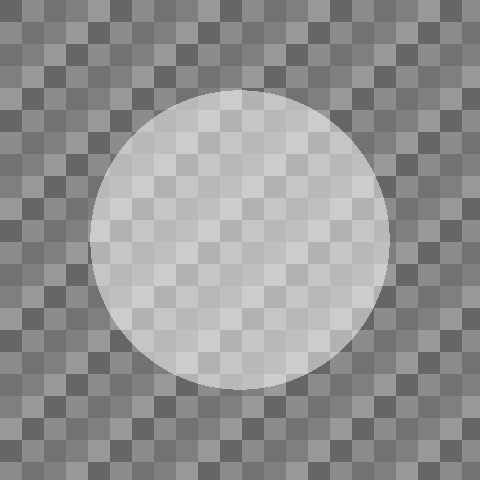

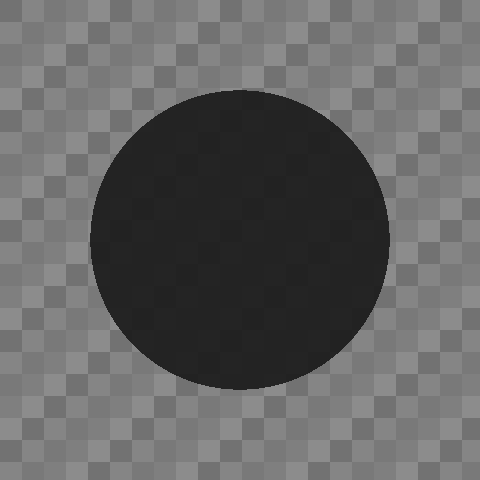

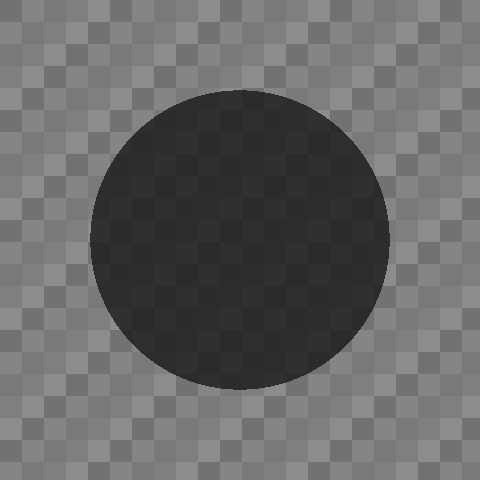

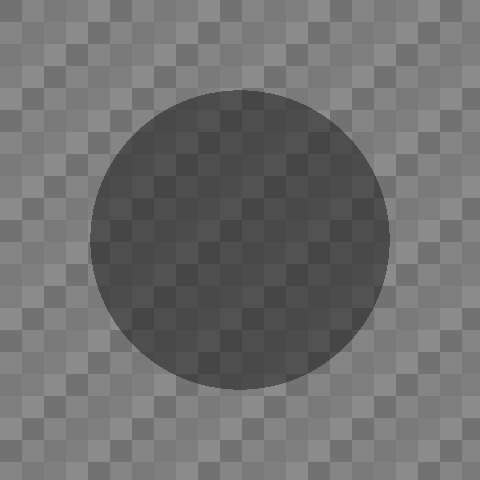

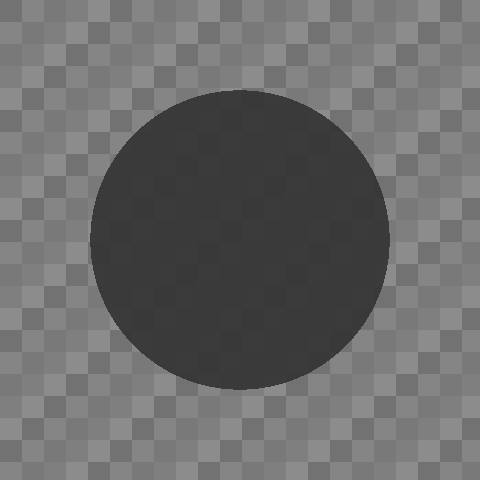

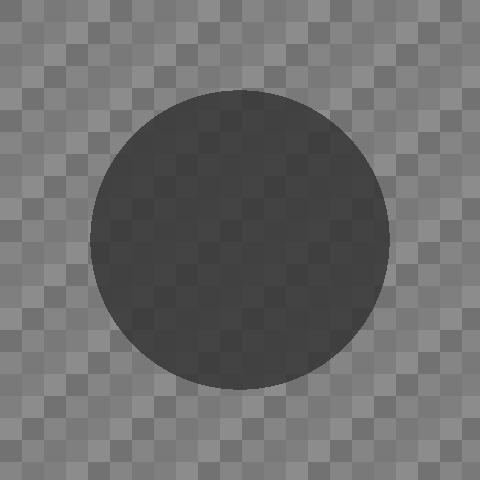

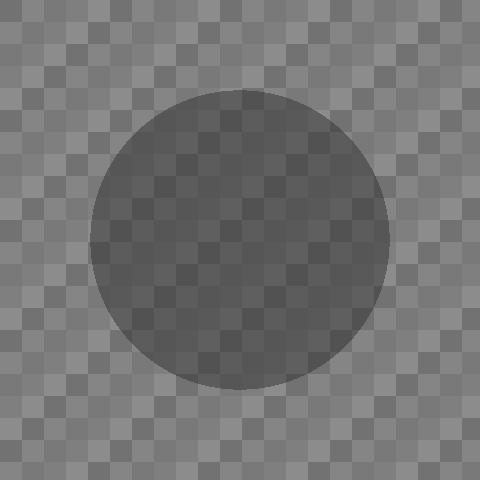

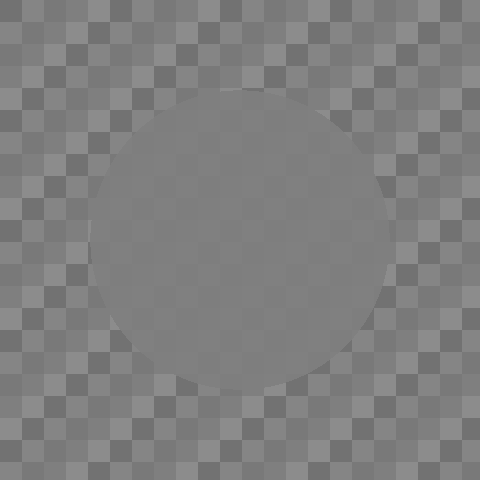

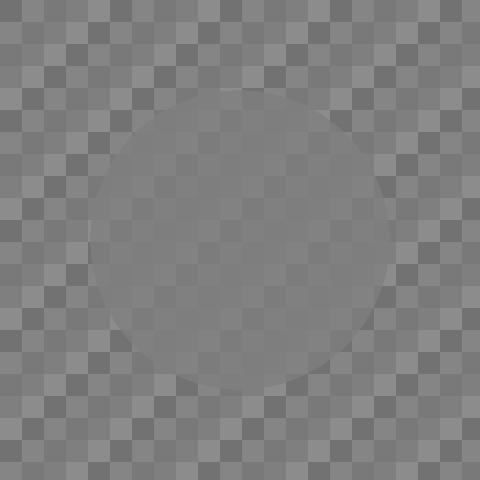

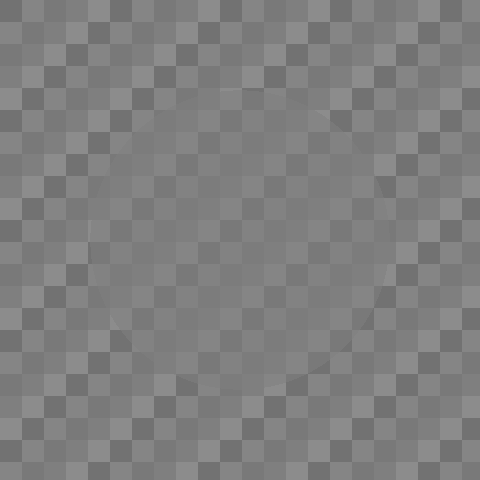

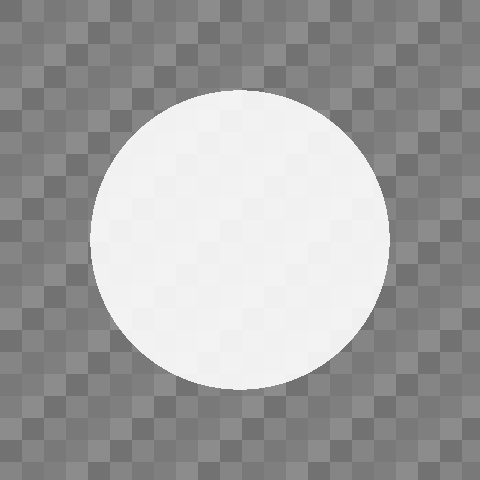

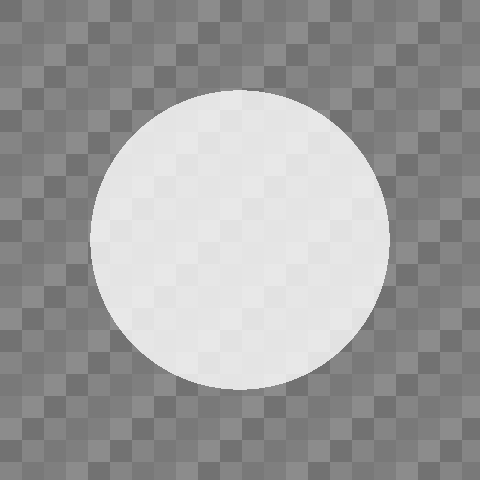

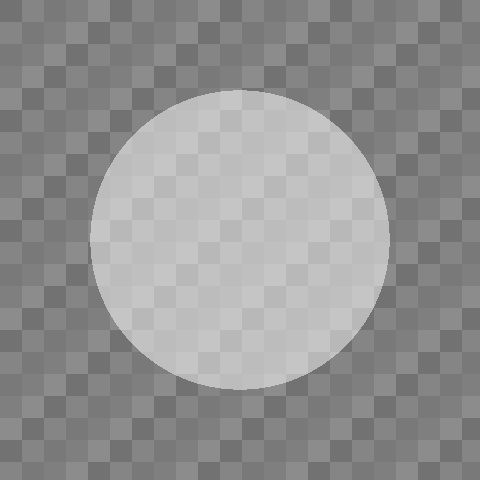

In [15]:
im_arrays = []
for i in range(0,len(images)): 
    im = to_array(i)
    im_arrays.append(im)  

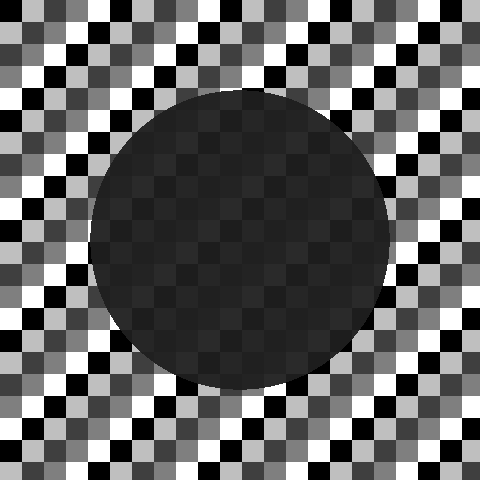

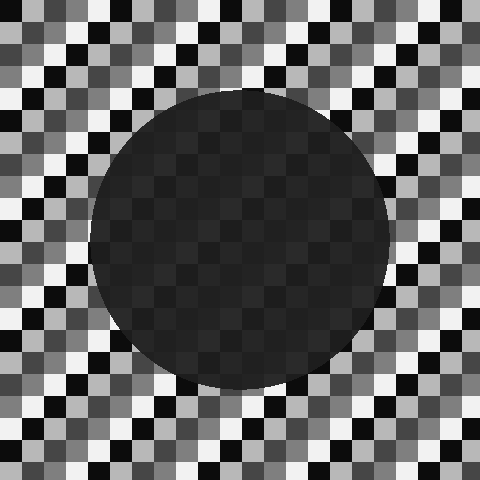

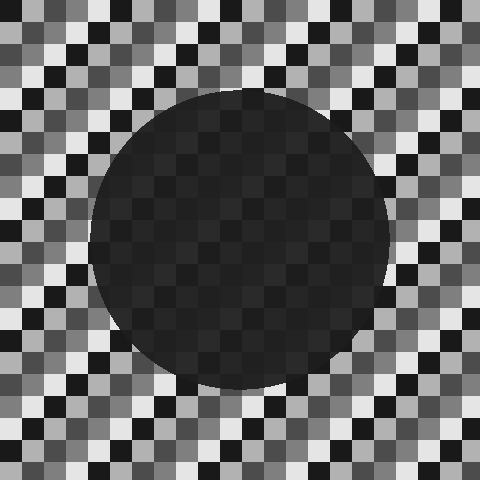

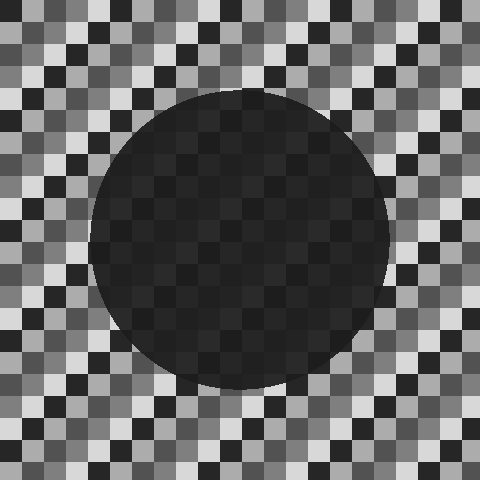

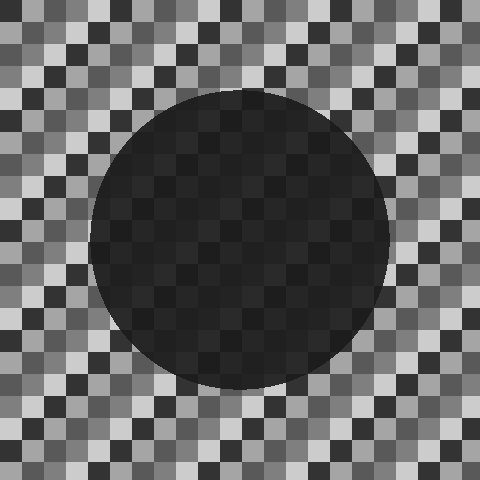

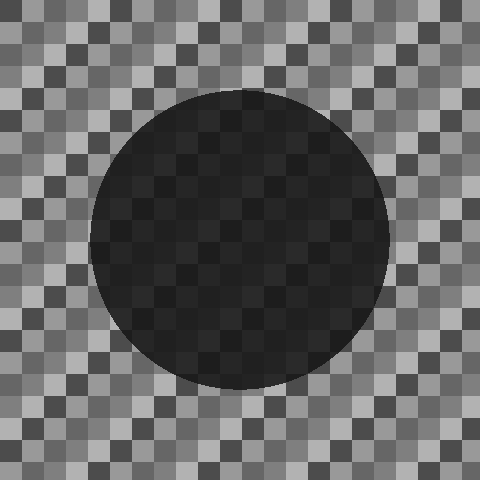

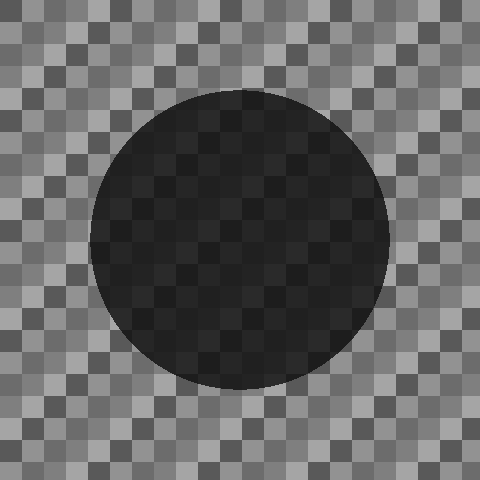

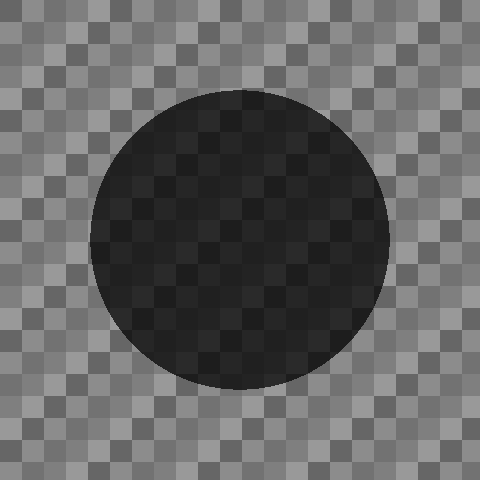

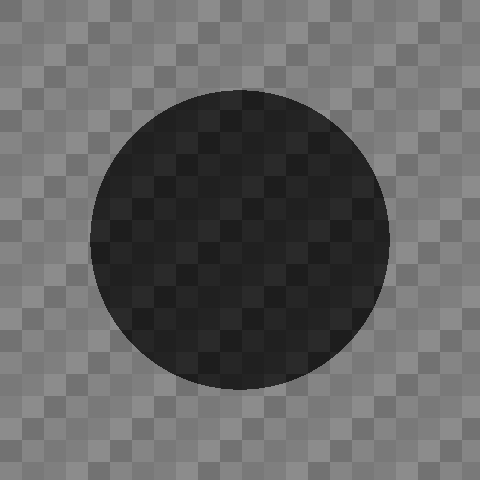

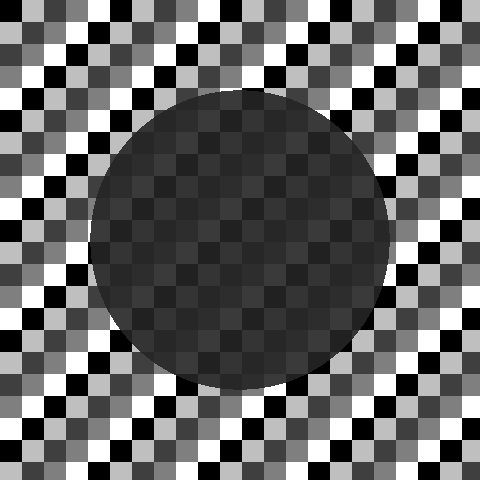

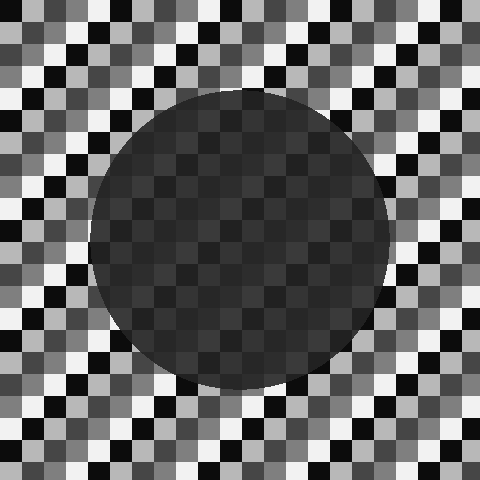

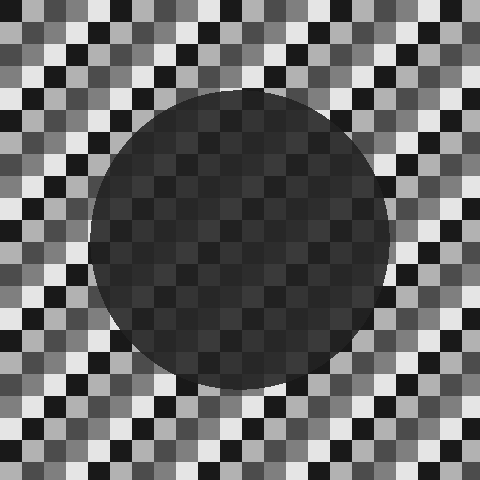

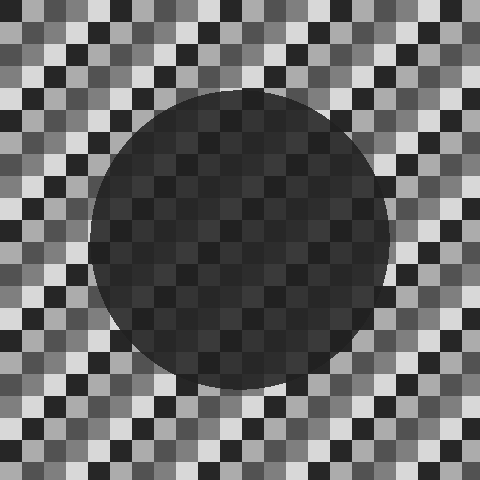

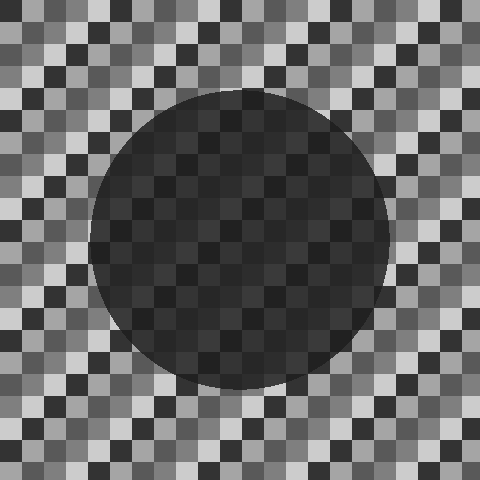

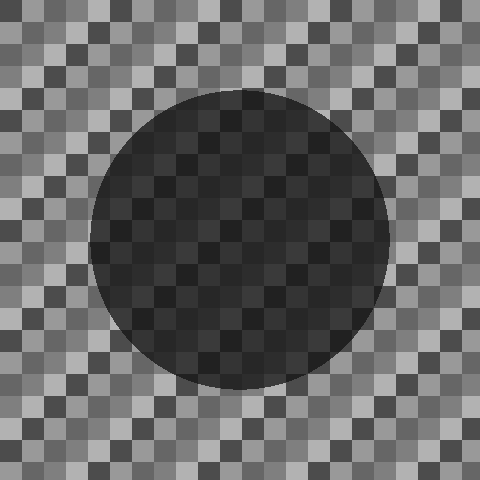

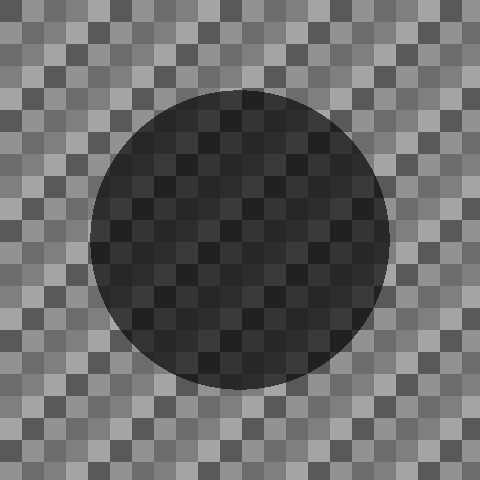

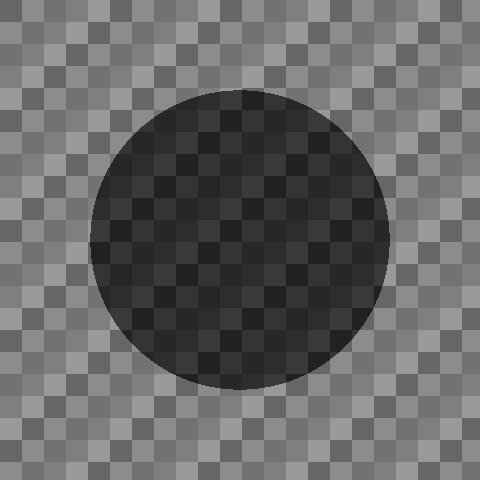

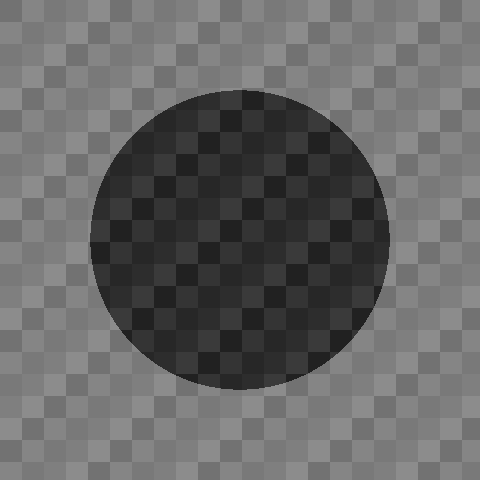

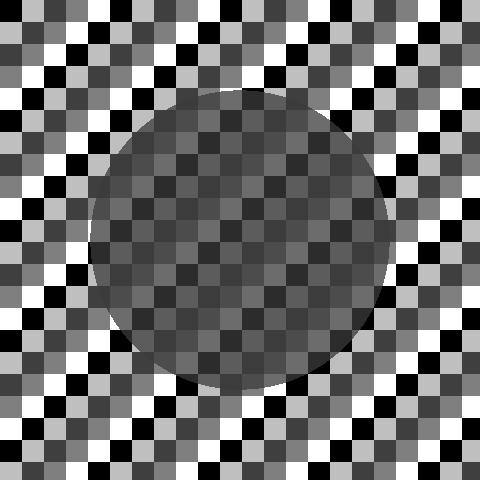

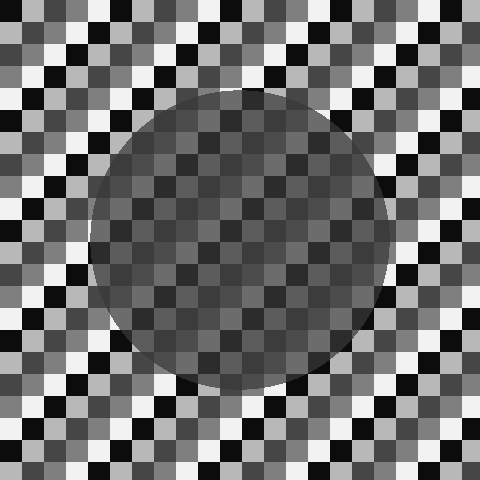

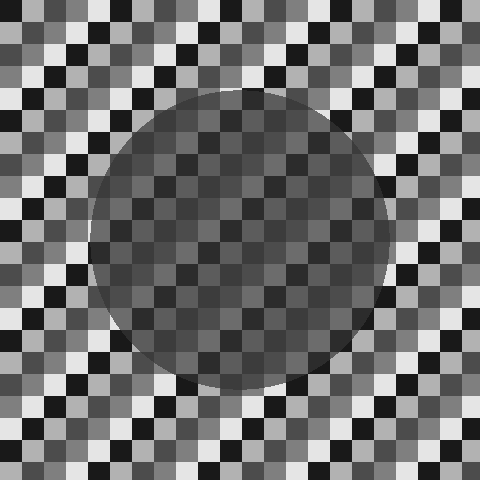

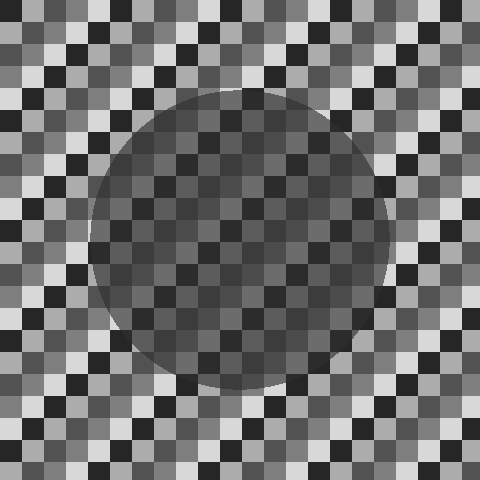

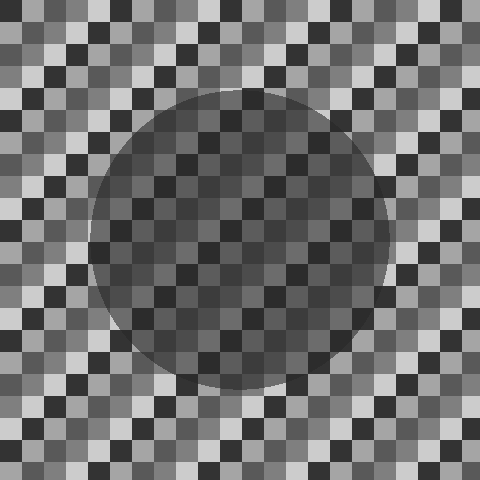

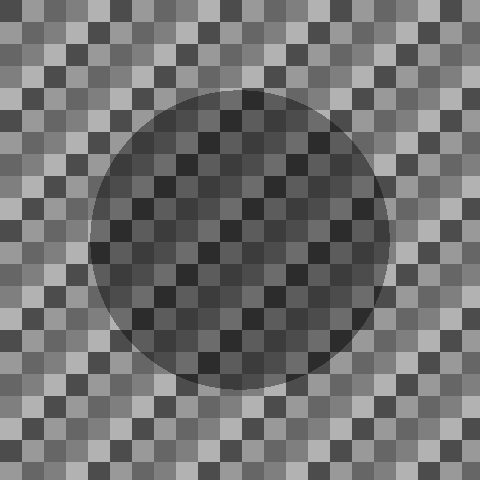

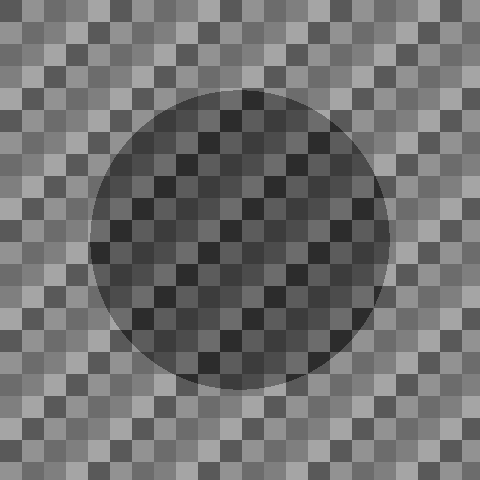

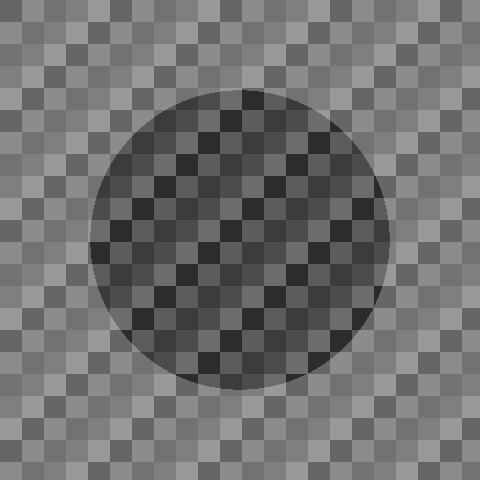

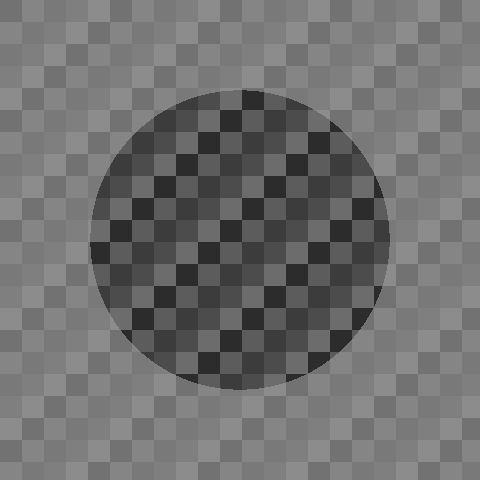

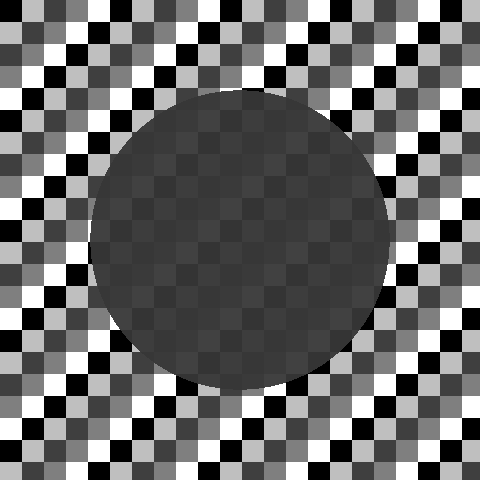

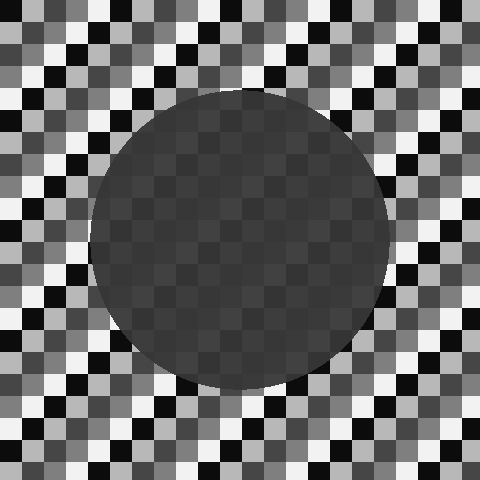

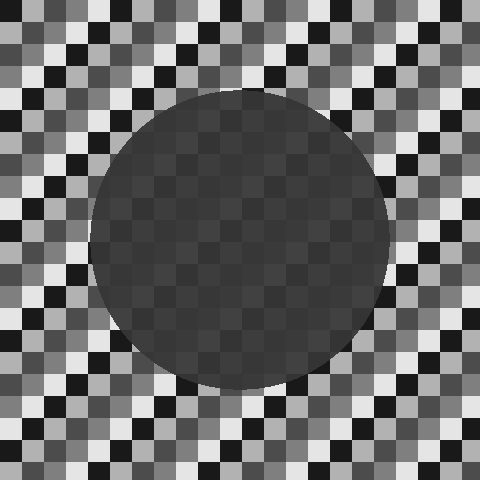

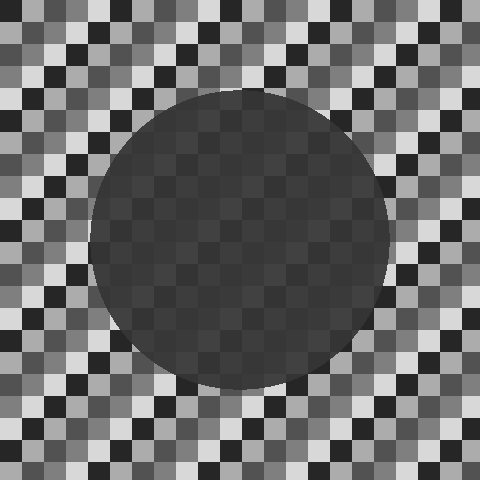

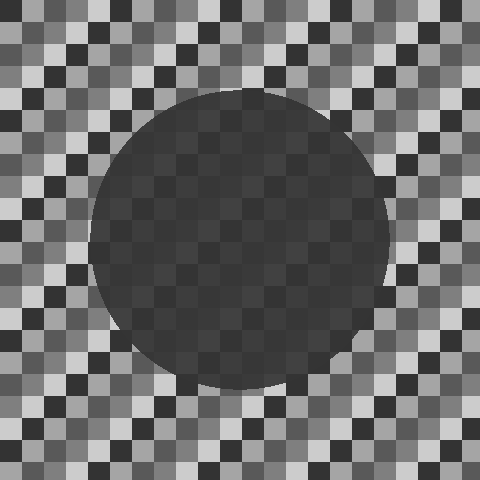

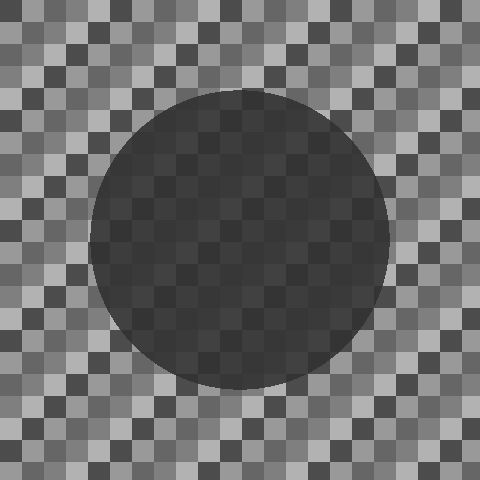

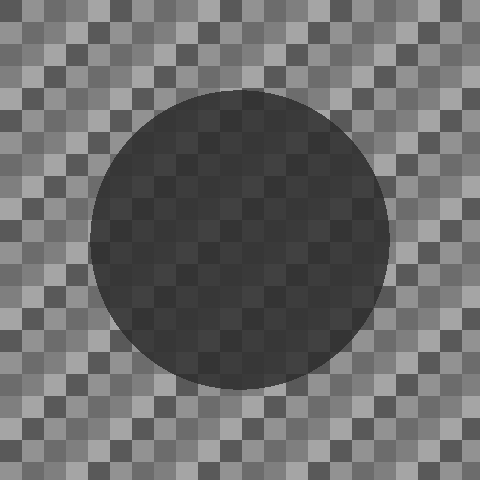

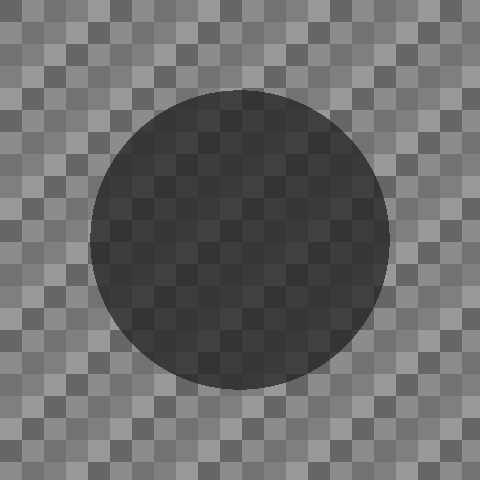

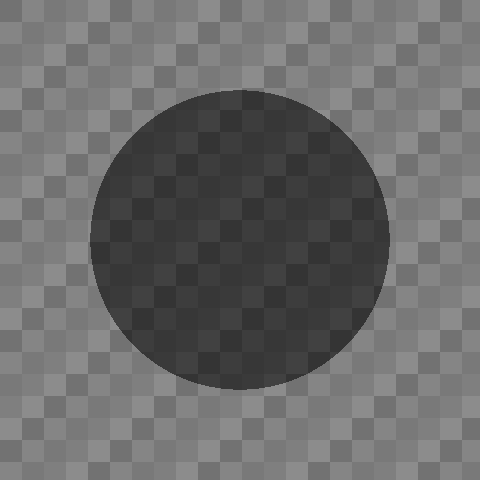

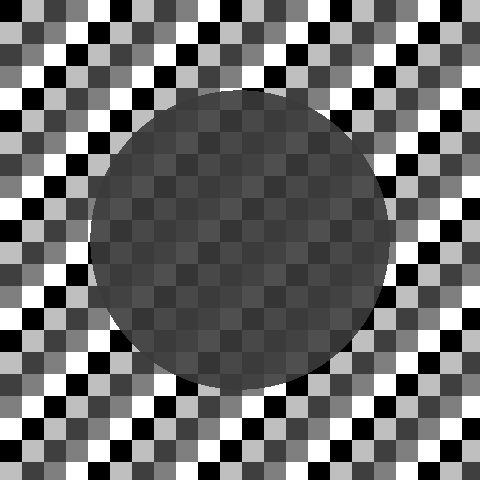

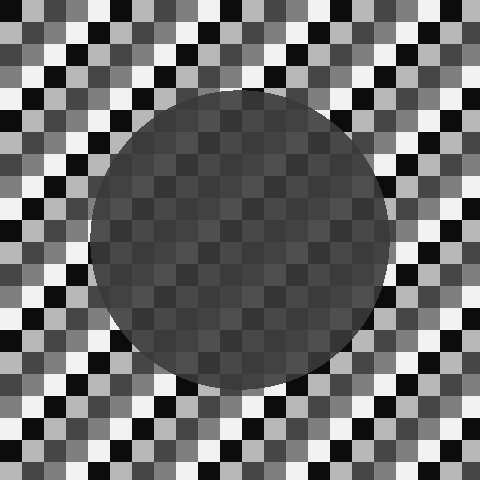

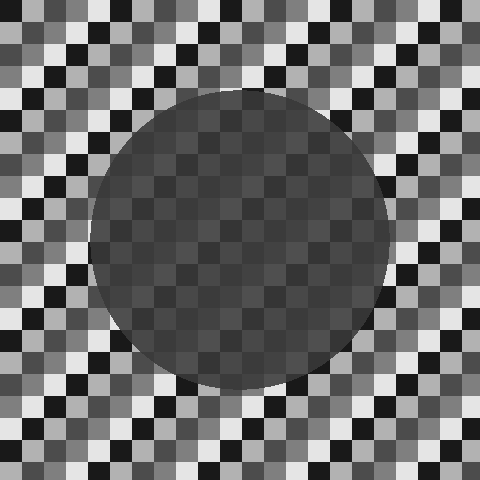

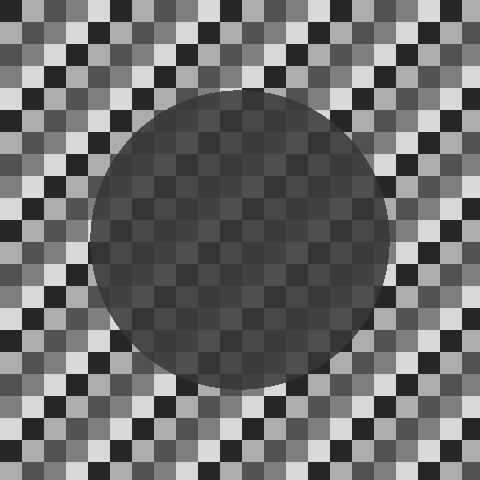

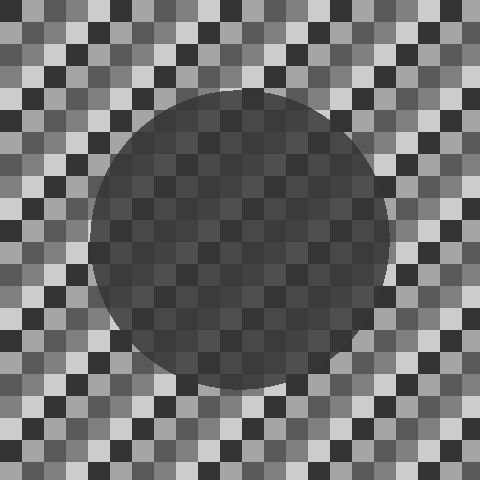

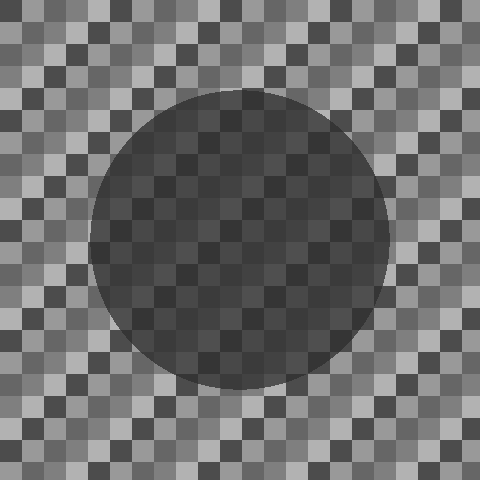

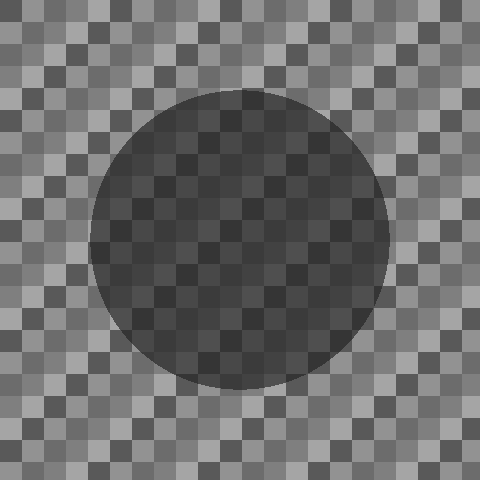

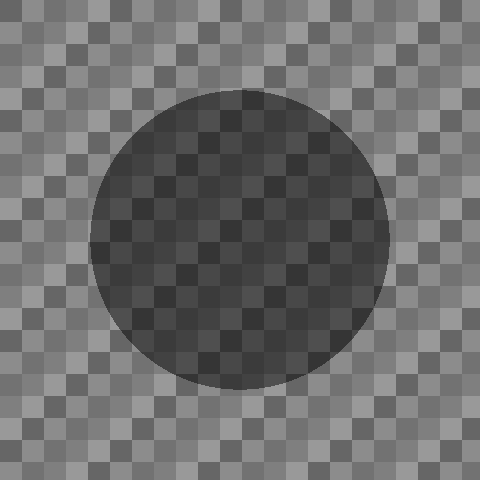

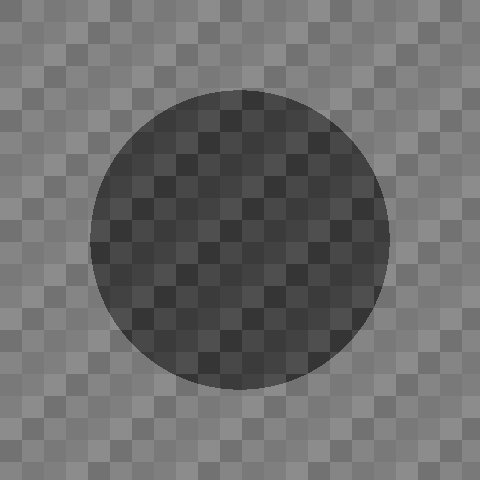

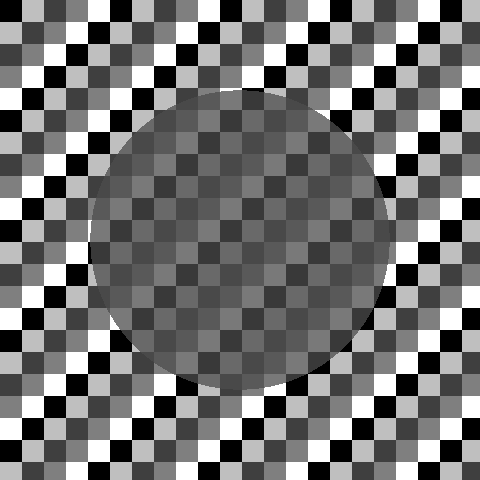

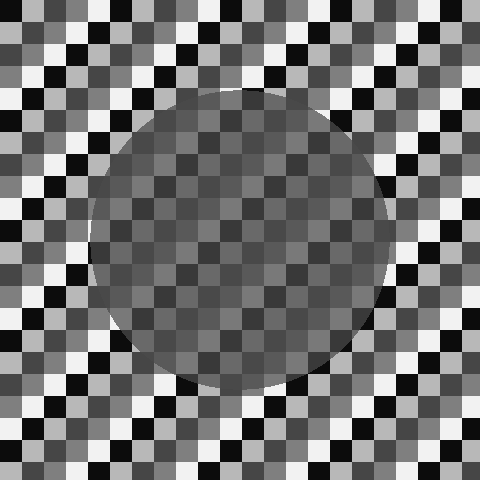

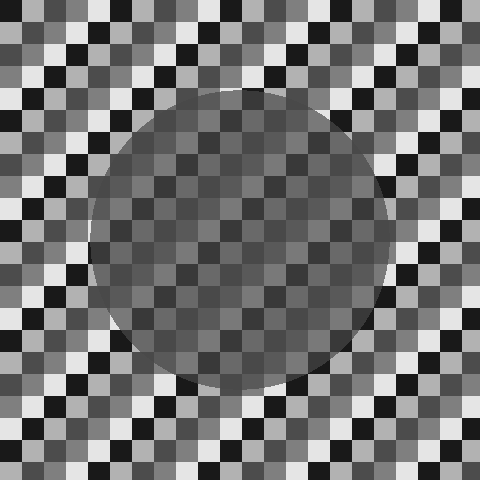

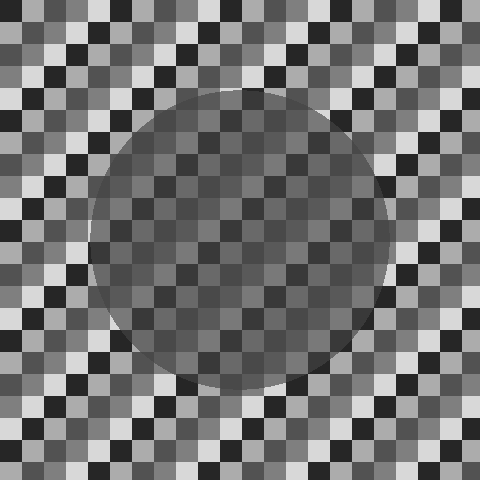

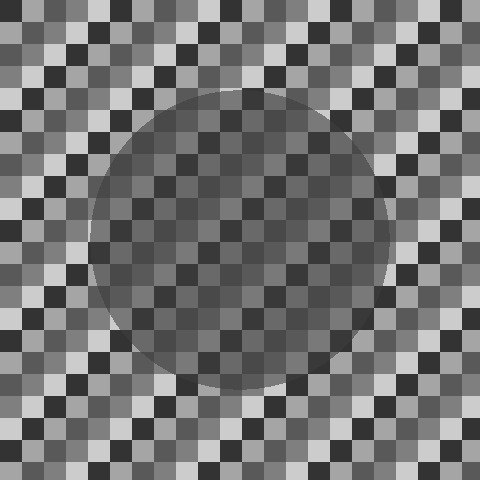

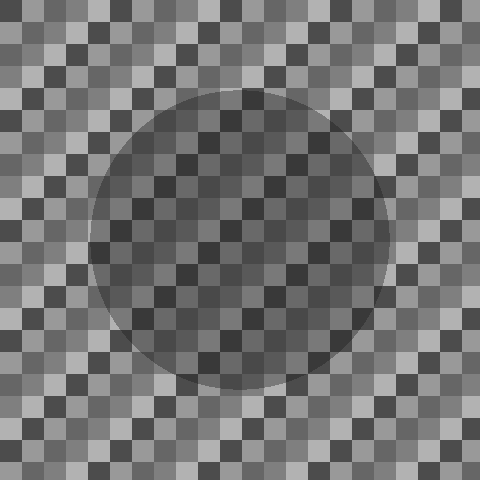

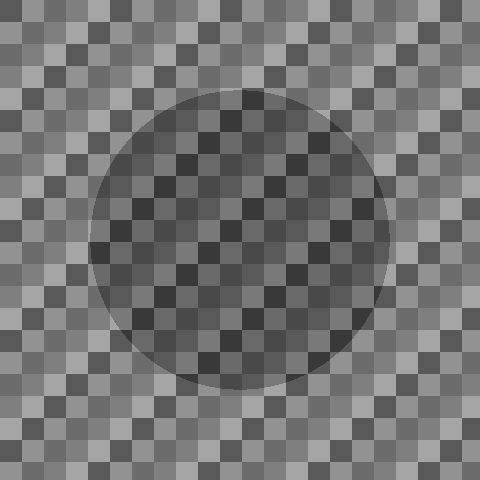

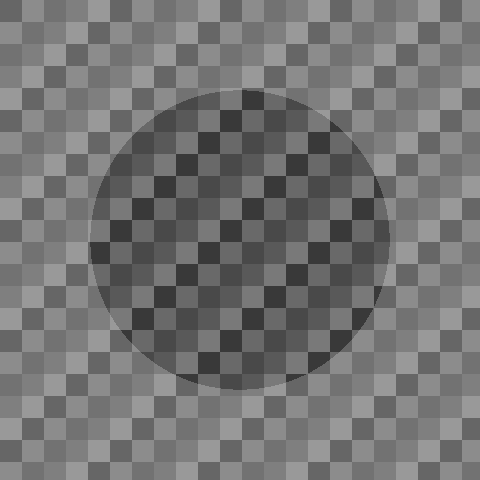

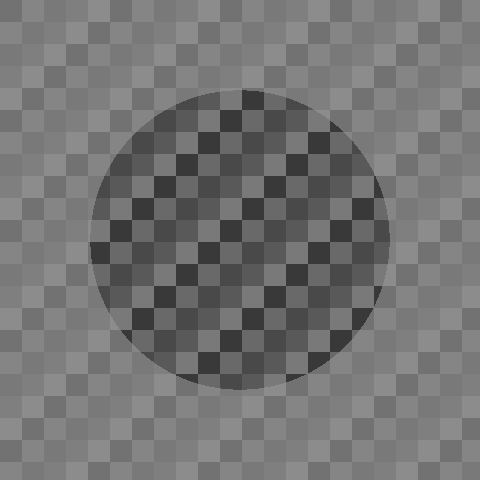

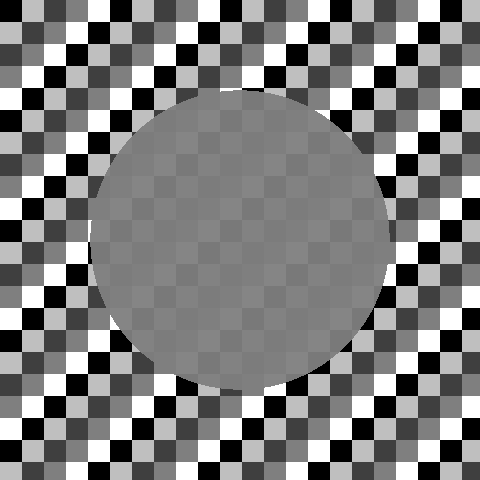

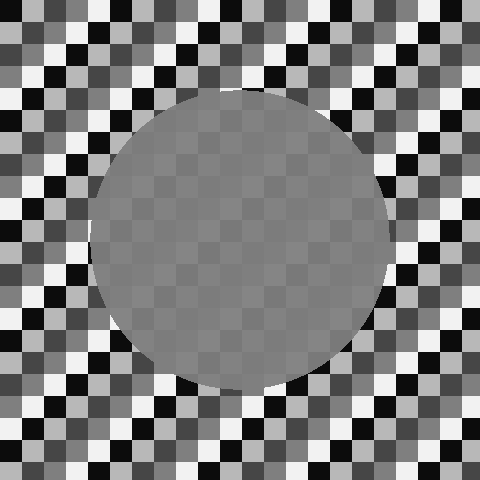

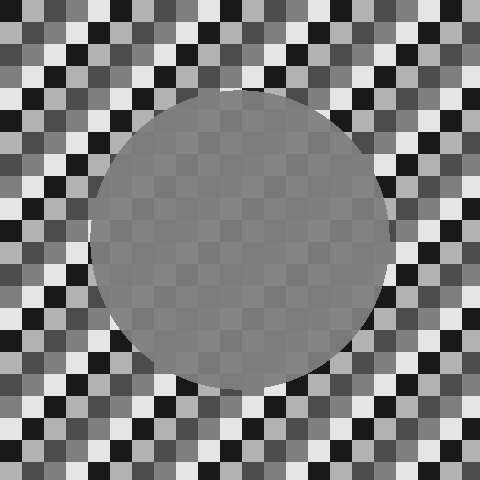

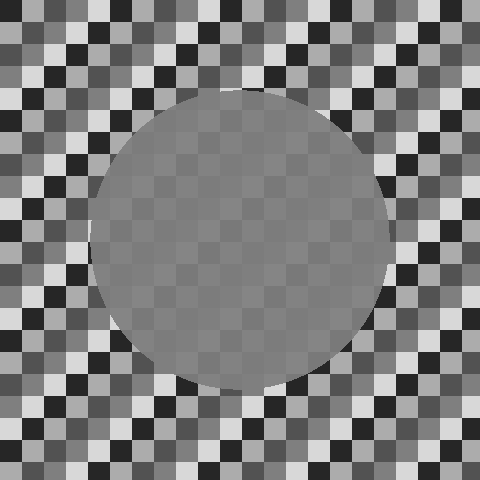

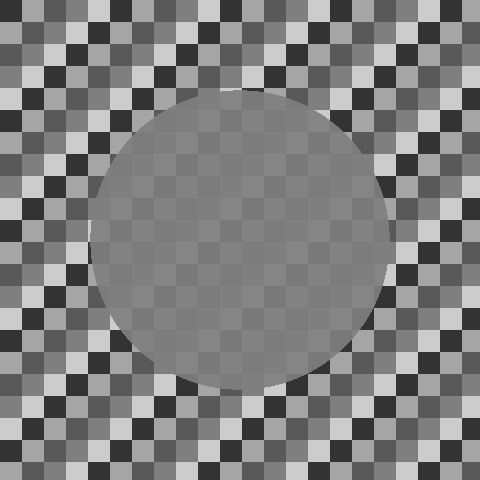

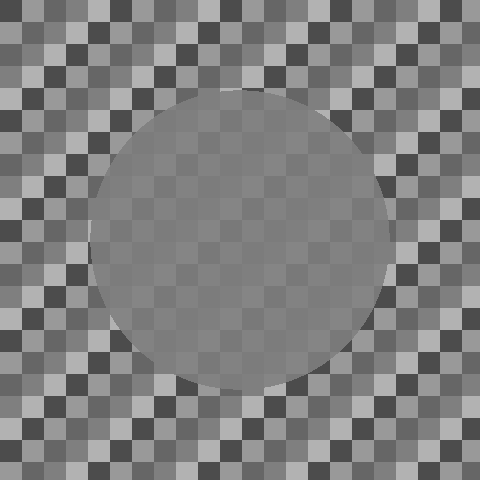

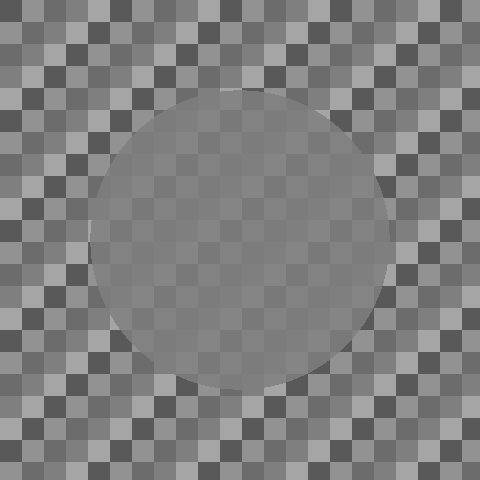

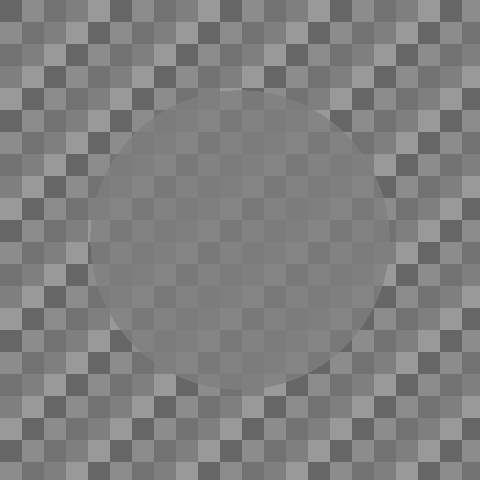

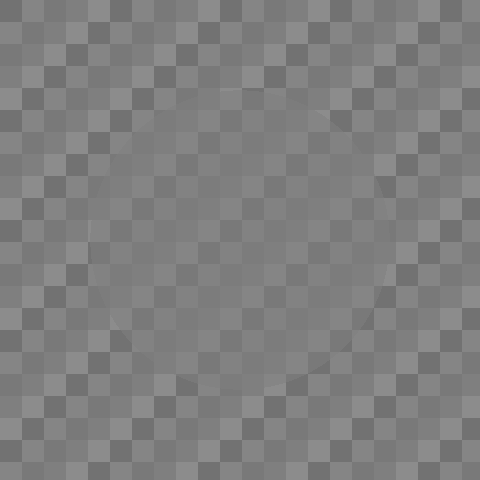

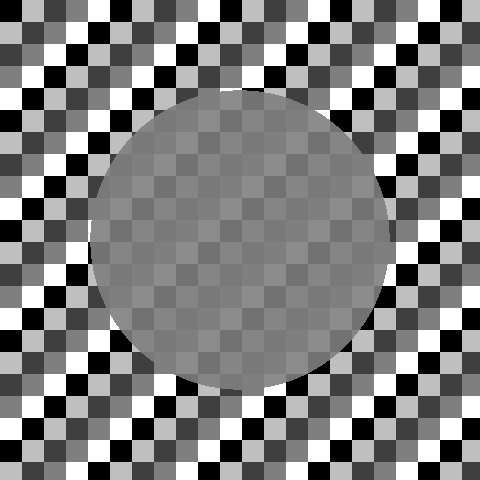

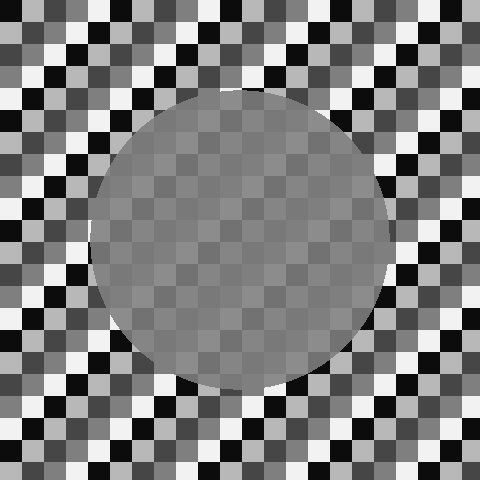

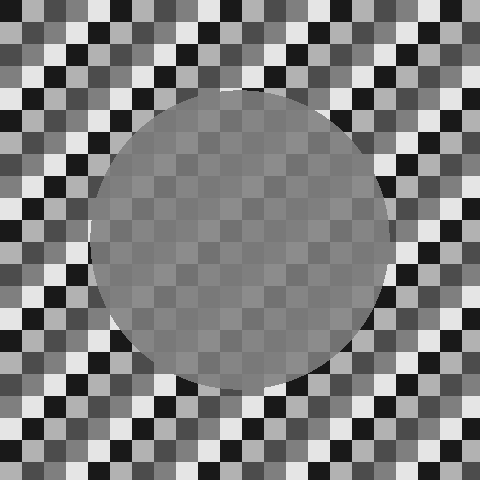

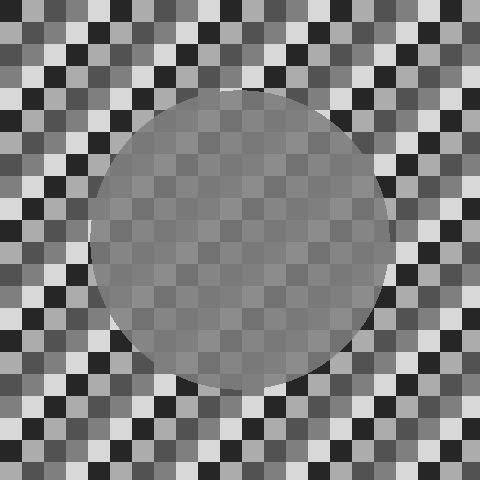

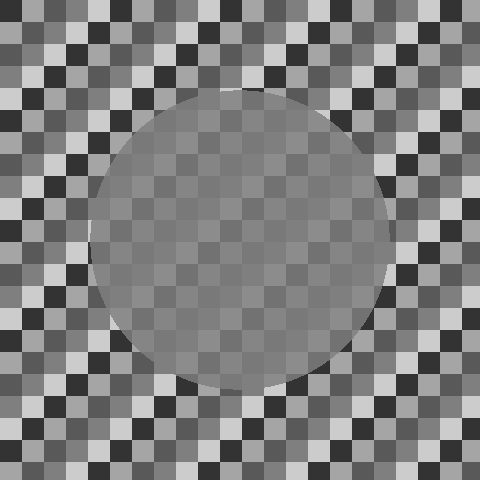

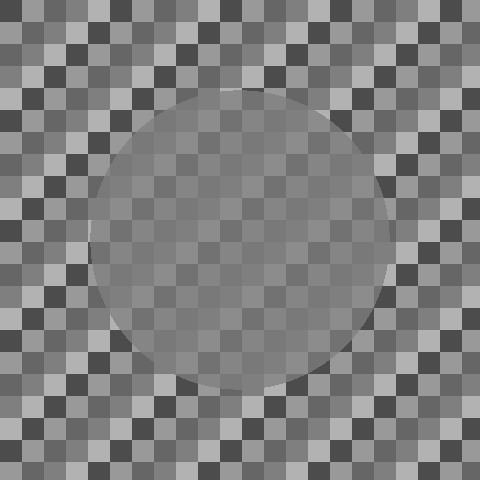

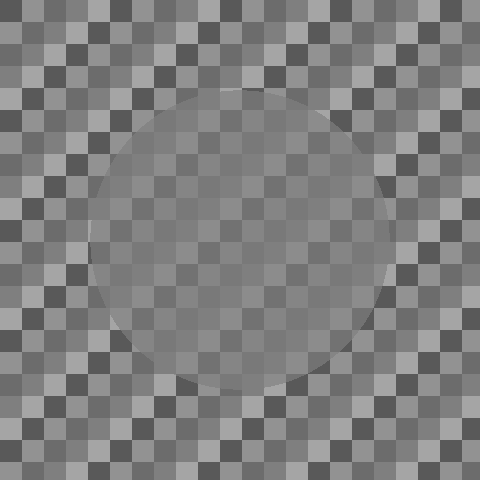

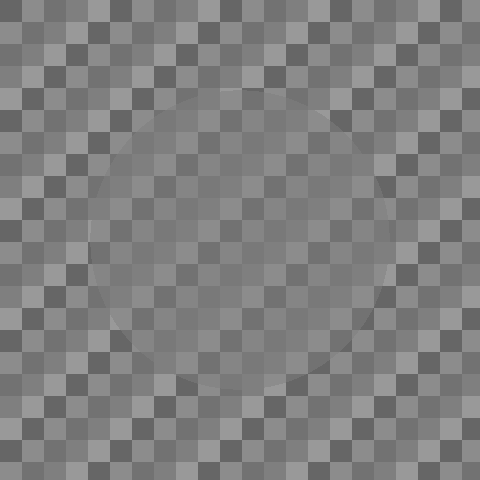

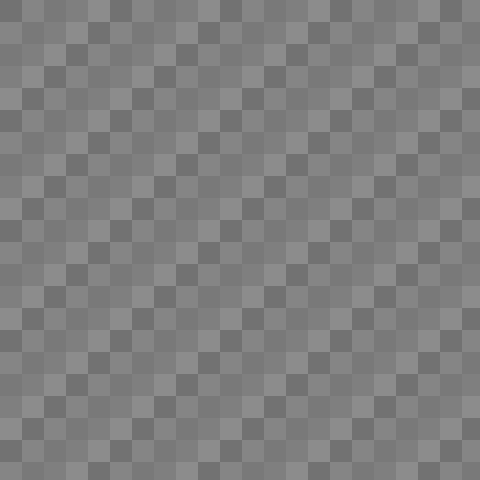

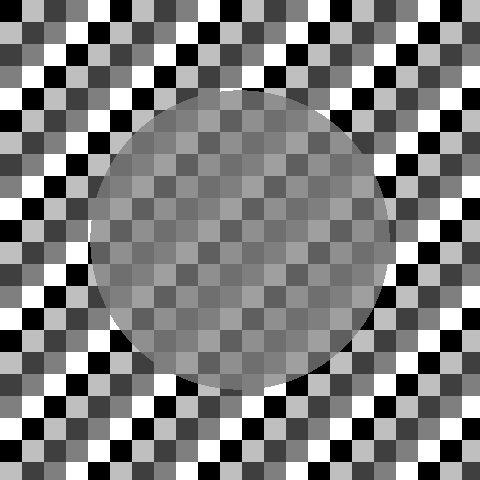

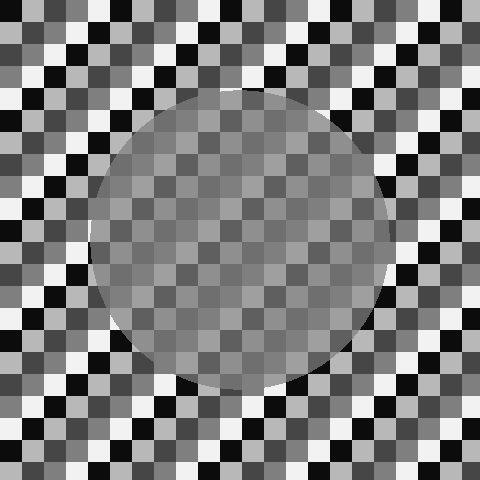

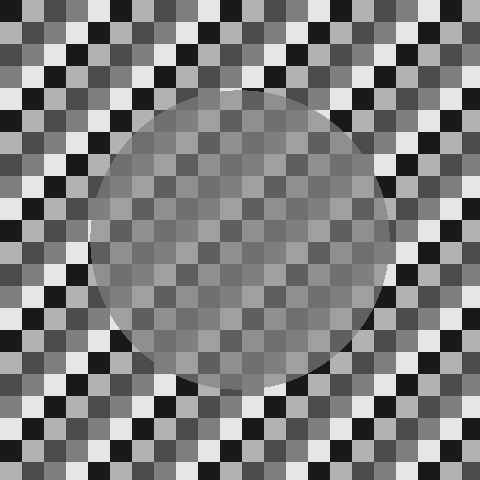

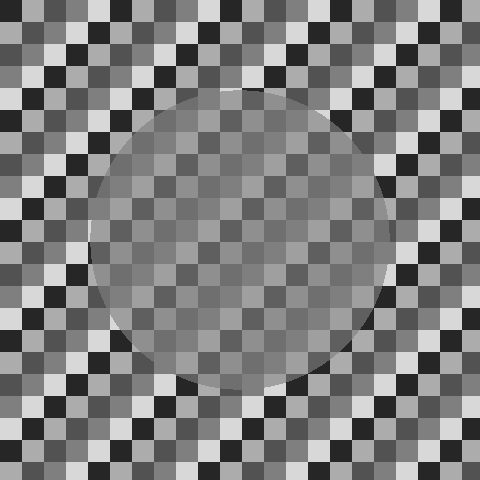

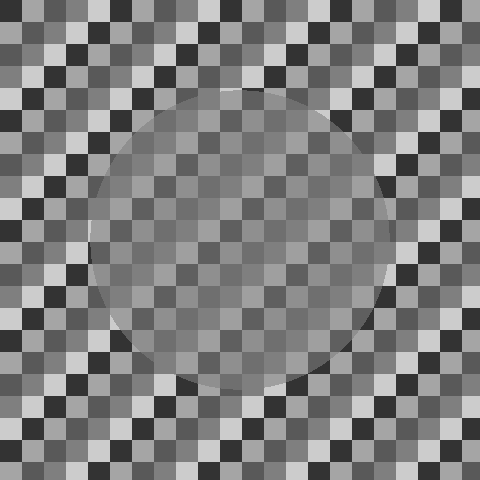

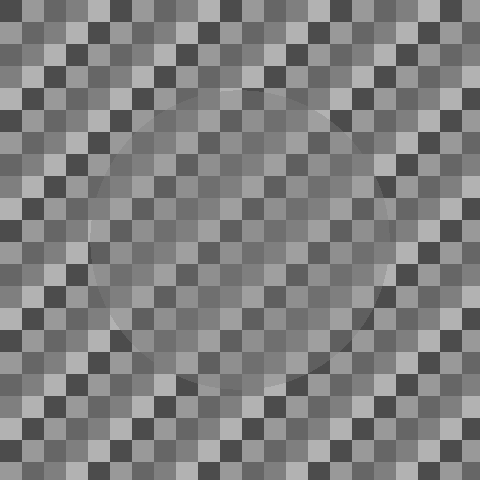

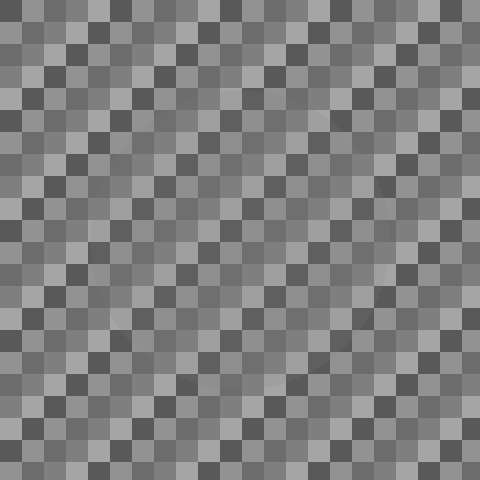

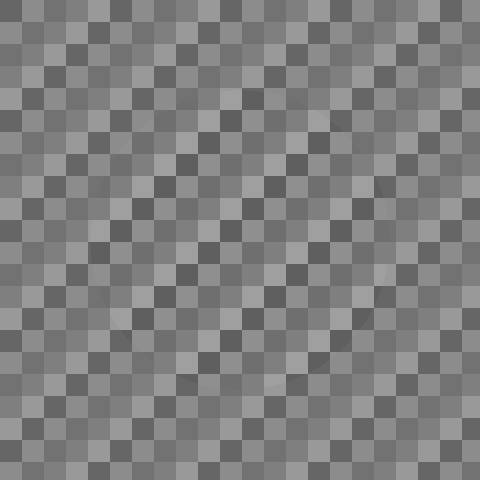

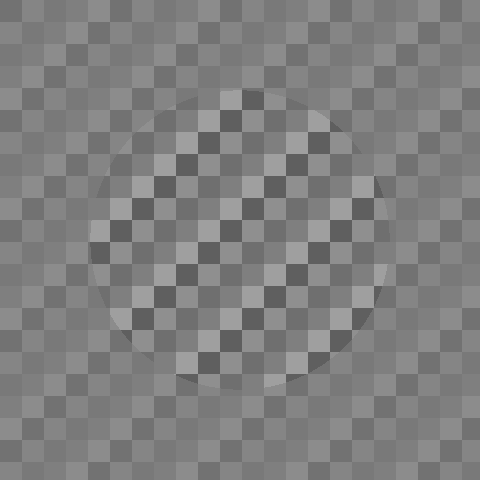

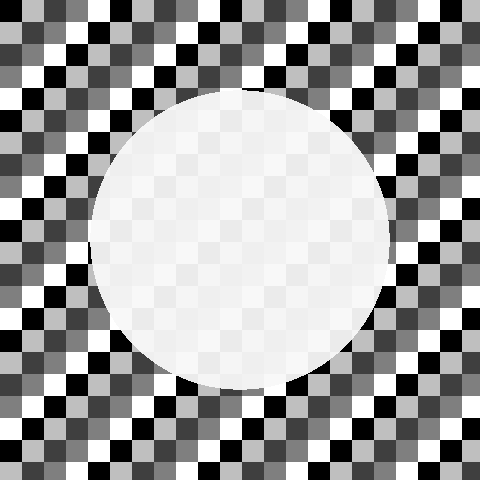

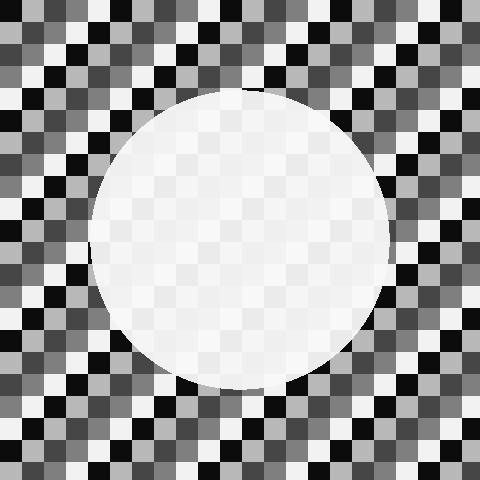

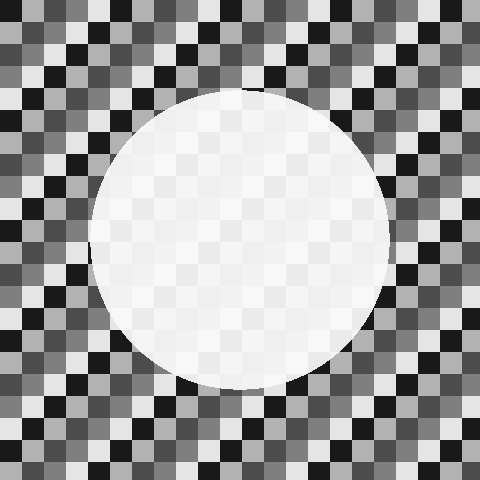

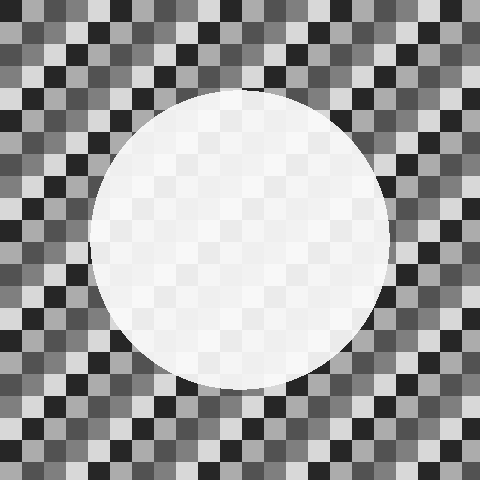

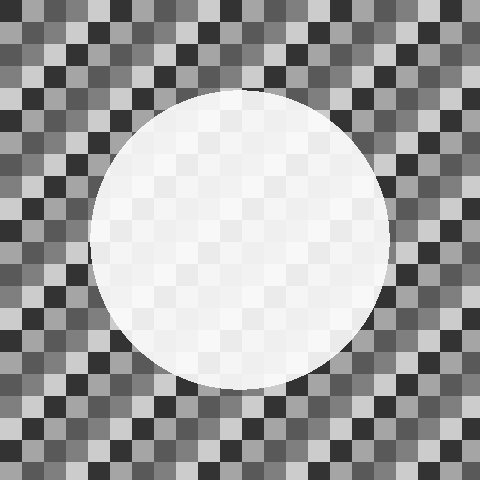

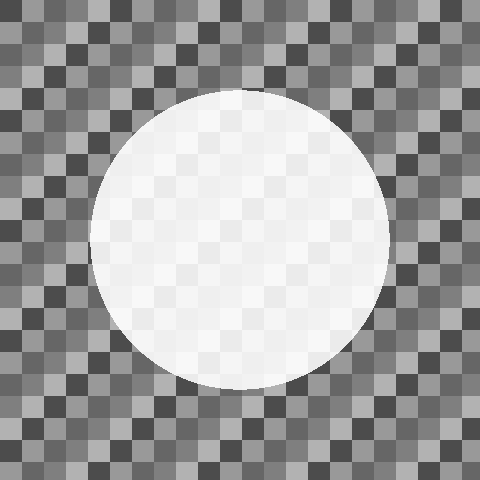

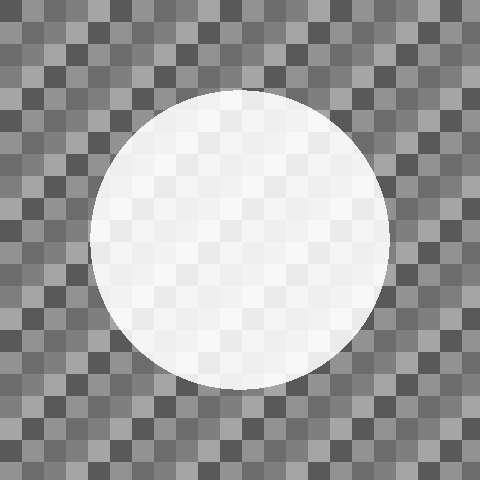

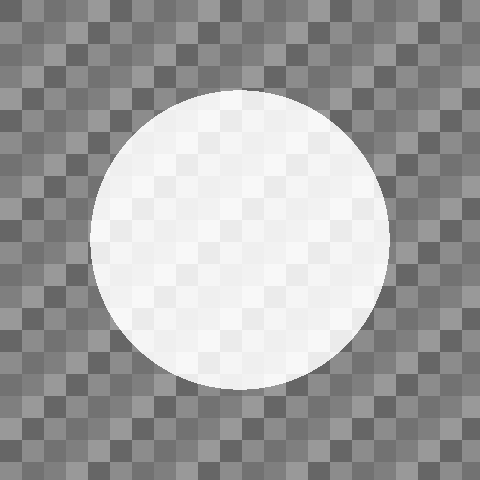

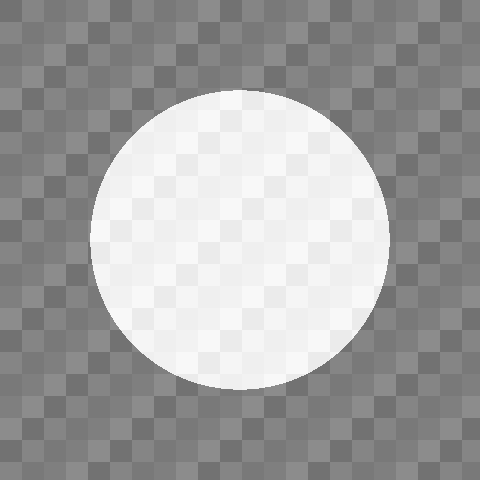

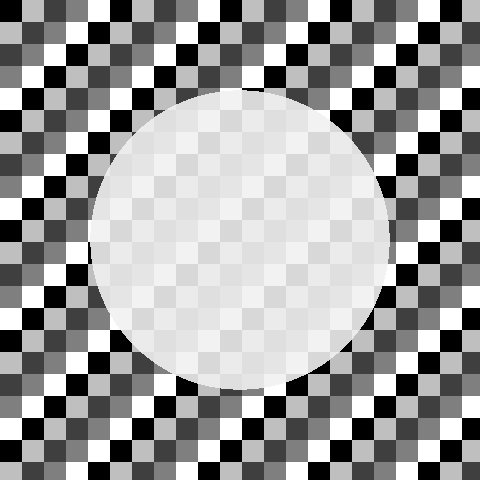

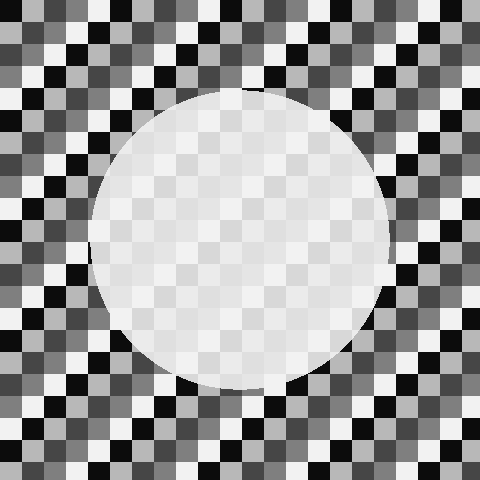

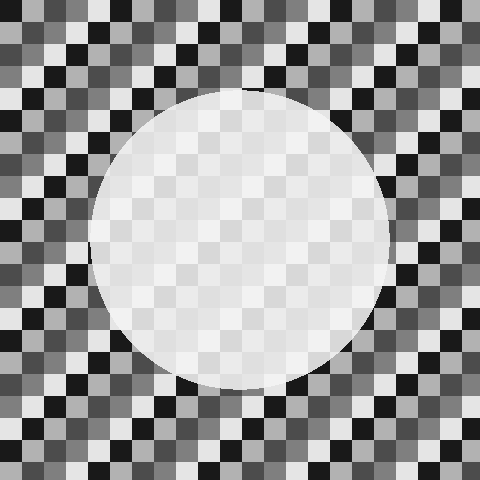

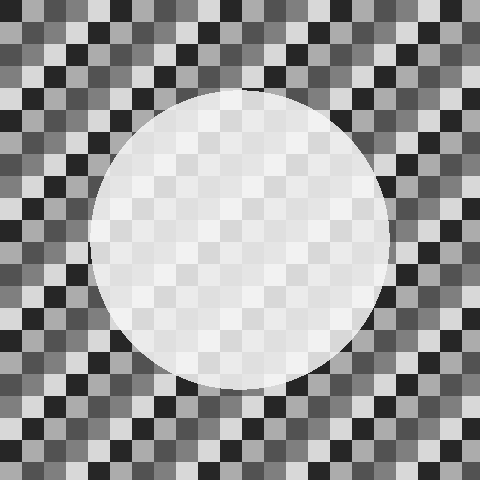

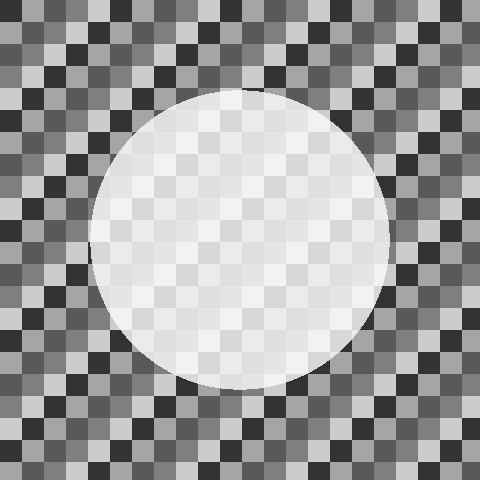

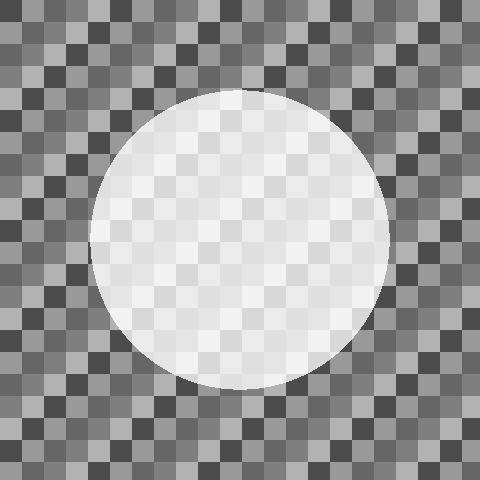

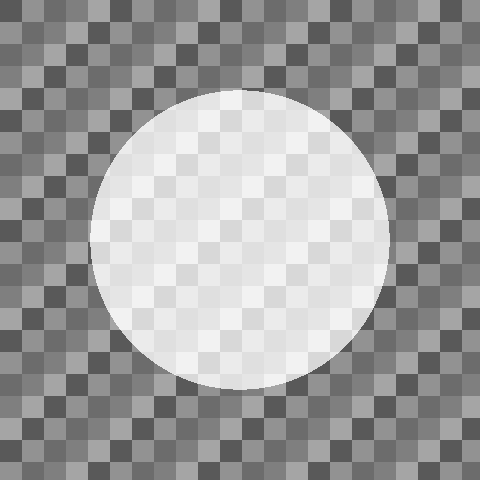

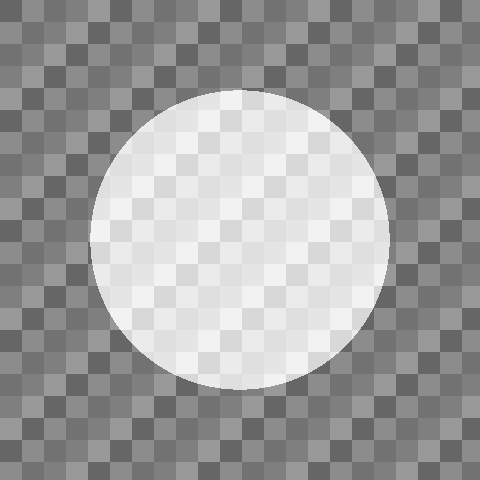

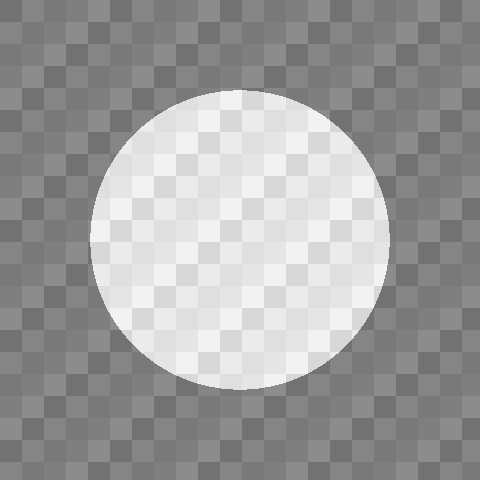

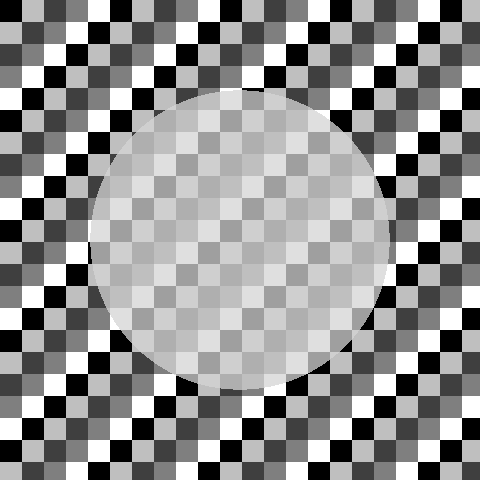

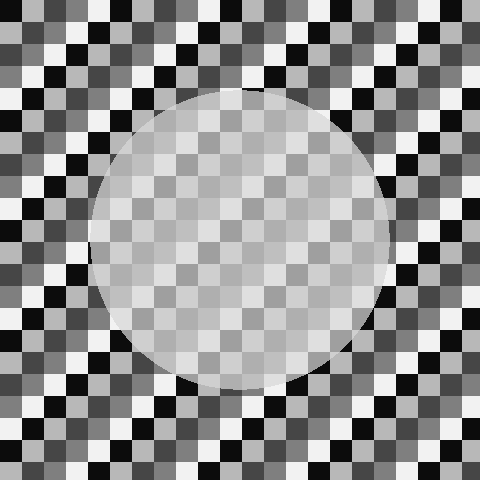

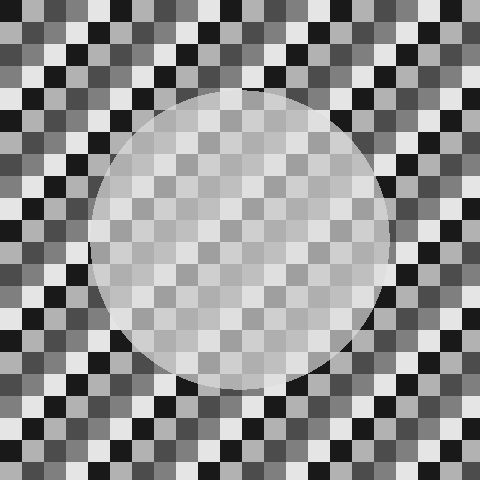

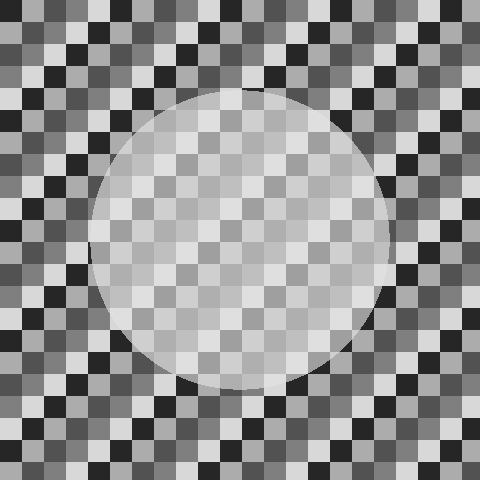

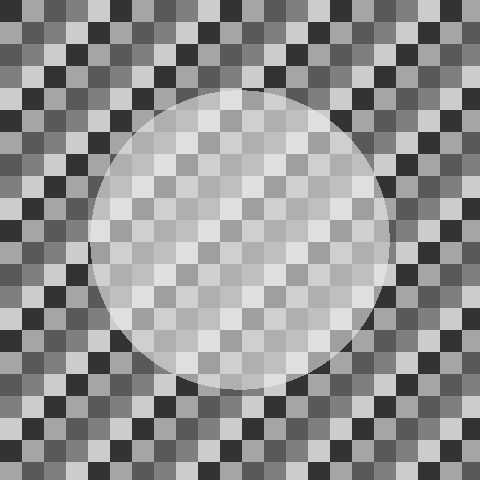

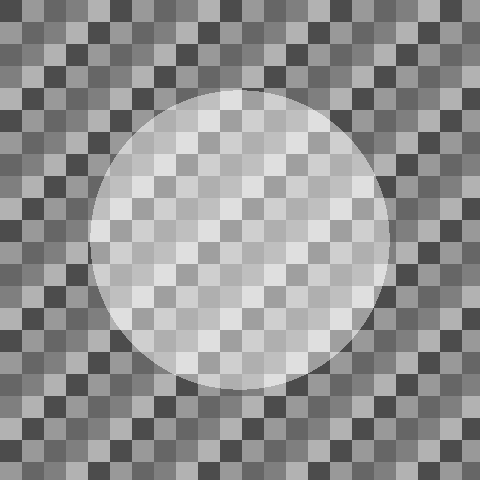

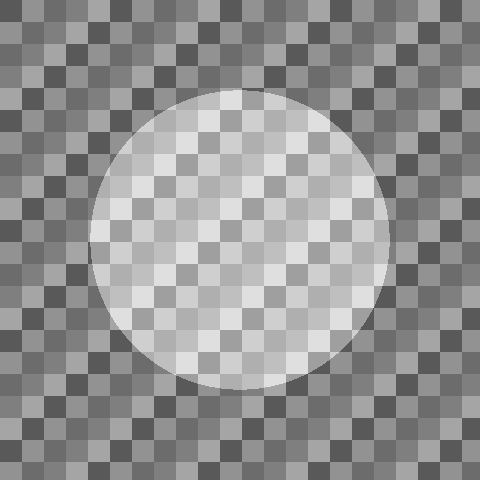

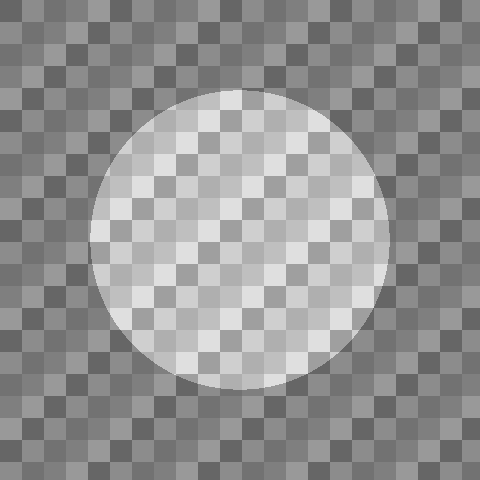

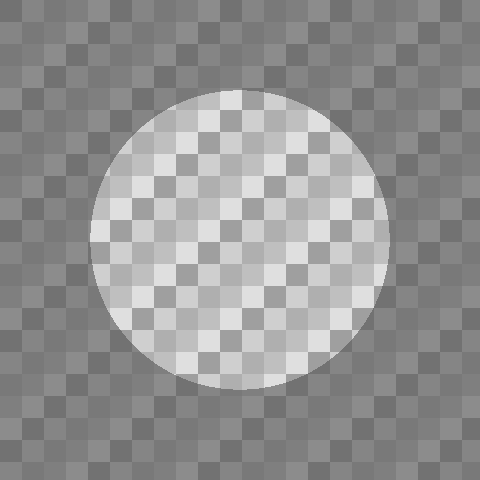

120


In [17]:
# The transparent media with alpha and tau values on the background with highest contrast
# is cut out and pasted on variegated checkerboards with different background contrasts.

stimuli = []
for i in range(60,72): # if you take TM from lowest BG, write range(108,119); if you take TM from highest BG, write range(0-12); if you take TM from BG=0.5, write range(60,72)
    tm = images[i] # image which transparent medium is taken from (stimuli with highest bg contrast)
    stimuli.append(np.array(tm))
    for j in range(i-60, len(images), 12): # lowestBG: (i-108, len(images)-12, 12); highestBG: (i+12, len(images), 12); BG=0.5: (i-60, len(images), 12)
       
        if j == i: # delete this if condition if you dont take BG=0.5
            continue
        bg = images[j] # image to put it
        back_im = bg.copy() 
        back_im.paste(tm, (0, 0), mask_im) # replaced 
        im = np.array(back_im)
        
        stimuli.append(im)
        # display(im)    # shows the stimuli as an array
        img = Image.fromarray(im, 'L')
        display(img)
        # img.save(f"Stimuli_MID/{i}.png")  # lowestBG: img.save(f"Stimuli_LOW/{i}.png"); highestBG img.save(f"Stimuli_HIGH/{i}.png"); BG=0.5 img.save(f"Stimuli_MID/{i}.png")
        # img.save(f"Stimuli_MID/{j}.png")  # lowestBG: img.save(f"Stimuli_LOW/{j}.png"); highestBG img.save(f"Stimuli_HIGH/{j}.png"); BG= 0.5 img.save(f"Stimuli_MID/{j}.png")
    
    
print(len(stimuli))

In [18]:
# now we apply the mask to the numpy array
def get_values_bg_and_tm(i):
    
    im = stimuli[i]
    center = im[mask==1.0]

    # center vector has only the values in the transparent region. We now
    # get the unique values in it
    
    transp_values = np.unique(center)/255
    transp_values = transp_values.round(2)
    # print('values inside transparent medium of the image',i,":", transp_values.round(2))

    # and we do the same for the surround - region without transparency
    surr = im[mask==0.0]

    surr_values = np.array(surr)
    
    surr_values = np.append(surr_values, surr_values)
    
    surr_values = np.unique(surr_values)/255
    # print('values in the background of the image',i,":", surr_values.round(2))
    return transp_values.round(2), surr_values.round(2)



In [19]:
# get values inside and outside of transparent medium for every stimuli
outside = []
inside = []
for i in range(len(stimuli)):
    a,b = get_values_bg_and_tm(i)
    inside.append(a)
    outside.append(b)

In [20]:
# Calculation of the Michelson contrast

def mc(arr):
    return abs((arr.max() - arr.min())/(arr.max() + arr.min()))

contrast_bg_mc = []
MC_values_bg = [] 

# we iterate through all pairs of values out of transparency (in the background)
for k in range(len(stimuli)): 
    n = len(outside[k])
      
    # michelson contrast OUTSIDE
    
    c = abs(mc(outside[k]))
    contrast_bg_mc = c
    MC_values_bg.append(c.round(2))
    
    # print('MC in background of image ',k,":", contrast_bg_mc.round(1)) # prints the MC of each stimulus
print("Every MC of outside values: ",MC_values_bg) # a list with every MC of outside of each stimulus (144)


contrast_transp_mc = []
MC_values_transp = []

    # we now iterate through all pairs of values inside the transparency 
for k in range(len(stimuli)):    
    m = len(inside[k])
    

    # michelson contrast INSIDE

    c = abs(mc(inside[k]))
    contrast_transp_mc = c
    MC_values_transp.append(c.round(2))
    
    # print('MC inside the transparency of image ',k,":",contrast_transp_mc.round(2)) # prints the MC of each stimulus 
print("Every MC of inside values: ",MC_values_transp) # a list with every MC of inside of each stimulus (144)


Every MC of outside values:  [0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1]
Every MC of inside values:  [0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36,

In [10]:
# now we calculate the Space-averaged Michelson contrast as in the paper Aguilar & Maertens (2022)
def michelson_contrast(a, b):
    return abs(a-b)/(a+b)

contrast_bg_sam = []
SAM_values_bg = []
SAMLG_values_bg = []

# we iterate through all pairs of values out of transparency (in the background)
for k in range(len(stimuli)): 
    n = len(outside[k])       



# contrast between all possible pairs, excluding when i==j, OUTSIDE
    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            c = abs(michelson_contrast(outside[k][i], outside[k][j]))
            contrast_bg_sam.append(c.round(2))
           

        
# we now calculate the log and sum
    contrast_bg = np.mean(contrast_bg_sam)
    
    samlg_bg = np.log(contrast_bg)
    SAMLG_values_bg.append(samlg_bg.round(3))
    
    SAM_contrast_bg = contrast_bg  
    SAM_values_bg.append(SAM_contrast_bg.round(3))
    
    
    
    # print('SAM in background of image ',k,":",SAM_contrast_bg.round(3))
    # print('SAMLG in background of image ',k,":",samlg_bg.round(3))
    contrast_bg_sam.clear() # cleared for the next stimuli



# because values in SAMLG are negative and it is problematic at calculating the ratio, we need to shift up the SAMLG values by summing minimum value to zero by adding the absolute minimum value to every item in the list.


sum_up  = list(np.asarray(SAMLG_values_bg) + abs(min(SAMLG_values_bg)))
summed_up_SAMLG_bg = [round(num, 3) for num in sum_up]


    
print("Every SAM of outside values: ",SAM_values_bg) # a list with every SAM of outside luminance values of each stimulus (144)
# print("Every SAMLG of outside values: ",SAMLG_values_bg) # a list with every SAM of outside luminance values of each stimulus (144)
print("Every summed up value of SAMLG of outside values: ", summed_up_SAMLG_bg)

    
    
    




# we now iterate through all pairs of values in transparency 

contrast_transp_sam = []
SAM_values_transp = []
SAMLG_values_transp = []

for k in range(len(stimuli)):
    n = len(inside[k])

# contrast between all possible pairs, excluding when i==j, INSIDE
    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            c = abs(michelson_contrast(inside[k][i], inside[k][j]))
            contrast_transp_sam.append(c.round(2))


# we now calculate the log and sum

    contrast = np.mean(contrast_transp_sam)
    samlg_transp = np.log(contrast)
    SAMLG_values_transp.append(samlg_transp.round(3))
    
    SAM_contrast_transp = contrast 
    SAM_values_transp.append(SAM_contrast_transp.round(3))
    
    # print('SAM in transparency of image ',k,":",SAM_contrast_transp.round(3))
    # print('SAMLG in transparency of image ',k,":",samlg_transp.round(3))
    contrast_transp_sam.clear() # cleared for the next stimuli

    # because values in SAMLG are negative and it is problematic at calculating the ratio, we need to shift up the SAMLG values by summing minimum value to zero by adding the absolute minimum value to every item in the list.

sum_up  = list(np.asarray(SAMLG_values_transp) + abs(min(SAMLG_values_transp)))
summed_up_SAMLG_transp = [round(num, 3) for num in sum_up]


print("Every SAM of inside values: ",SAM_values_transp) # a list with every SAM of inside luminance values of each stimulus (144)
# print("Every SAMLG of inside values: ",SAMLG_values_transp) # a list with every SAM of inside luminance values of each stimulus (144)
print("Every summed up value of SAMLG of inside values: ", summed_up_SAMLG_transp)

ValueError: min() arg is an empty sequence

In [ ]:
# now we calculate the Space-averaged Whittle contrast as in the paper Aguilar & Maertens (2022)
def michelson_contrast(a, b):
    return abs(a-b)/(a+b)

contrast_bg_saw = []
SAW_values_bg = []

# we iterate through all pairs of values out of transparency (in the background)
for k in range(len(stimuli)):
    n = len(outside[k]) 
    


# contrast between all possible pairs, excluding when i==j, OUTSIDE
    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            divisor = outside[k][i] - outside[k][j]
            dividor = min(outside[k][i], outside[k][j])
            dividor = 0.01 if dividor == 0 else dividor
            x = abs(divisor/dividor)
            contrast_bg_saw.append(x.round(2))

            
# we now calculate the sum
    contrast = np.mean(contrast_bg_saw)
    SAW_values_bg.append(contrast.round(3))
    # print('SAW in background of image ',k,":",SAW_contrast_bg.round(3))

    contrast_bg_saw.clear() # cleared for the next stimuli

print("Every SAW of outside values: ",SAW_values_bg) # a list with every SAW of outside luminance values of each stimulus (144)
    
    
    
    
    




# we now iterate through all pairs of values in transparency 

contrast_transp_saw = []
SAW_values_transp = []

for k in range(len(stimuli)):
    m = len(inside[k])



# contrast between all possible pairs, excluding when i==j, INSIDE
    for i in range(m):
        for j in range(i+1, m):
            if i == j:
                continue
            divisor = inside[k][i] - inside[k][j]
            dividor = min(inside[k][i], inside[k][j])
            x = abs(divisor/dividor)
            contrast_transp_saw.append(x.round(2))

# we now calculate the sum
    contrast = np.mean(contrast_transp_saw)
    SAW_values_transp.append(contrast.round(3))
    # print('SAW inside transparency of image ',k,":",SAW_contrast_transp.round(3))

    contrast_transp_saw.clear() # cleared for the next stimuli

print("Every SAW of inside values: ",SAW_values_transp) # a list with every SAW of inside luminance values of each stimulus (144)

In [ ]:
# we now calculate the ratio R between the contrasts inside and outside the transparent medium, R = tm_contrast / bg_contrast

r_mc_values = []
r_sam_values = []
r_samlg_values = []
r_saw_values = []


for i in range(len(stimuli)):
    

    # first, we calculate R_mc, being the Ratio between the Michelson contrasts 

    # we take calculated contrasts inside and outside the medium    
        
    mc_tm = MC_values_transp[i]
    mc_bg = MC_values_bg[i]

    # and calculate the ratio
    r_mc = abs(mc_tm/mc_bg).round(2)
    r_mc_values.append(r_mc)
    
    # print('Ratio of TM_mc / BG_mc of image ',i," = ", r_mc)


    # second, we calculate R_sam, being the Ratio between the Space-Average Michelson contrasts

    # we take calculated contrasts inside and outside the medium
    sam_tm = SAM_values_transp[i]
    sam_bg = SAM_values_bg[i]

    # and calculate the ratio
    r_sam = abs(sam_tm/sam_bg).round(2)
    r_sam_values.append(r_sam)
    # print('Ratio of TM_sam / BG_sam of image ',i," = ", r_sam)
    
   
    # third, we calculate R_samlg, being the Ratio between the Space-Average logarithm of Michelson contrasts
    
    samlg_tm = summed_up_SAMLG_transp[i]
    samlg_bg = summed_up_SAMLG_bg[i]
    samlg_bg = 0.01 if samlg_bg == 0 else samlg_bg

    # and calculate the ratio
    r_samlg = abs(samlg_tm/samlg_bg).round(2) 
    r_samlg_values.append(r_samlg)
    # print('Ratio of TM_samlg / BG_samlg of image ',i," = ", r_samlg)


    # lastly, we calculate R_saw, being the Ratio between the Space-Average Whittle contrasts

    # we take calculated contrasts inside and outside the medium
    saw_tm = SAW_values_transp[i]
    saw_bg = SAW_values_bg[i]

    # and calculate the ratio
    r_saw = abs(saw_tm/saw_bg).round(2)
    r_saw_values.append(r_saw)
    # print('Ratio of TM_saw / BG_saw of image ',i," = ", r_saw)
    
print("Every Ratio of MC: ", r_mc_values)
print("Every Ratio of SAM: ", r_sam_values)
print("Every Ratio of SAMLG: ", r_samlg_values)
print("Every Ratio of SAW: ", r_saw_values)

In [ ]:
pos_nosmc = [num for num in r_mc_values if num >= 1.0]
print("Positive numbers in the MC list: ", *pos_nosmc)

pos_nossam = [num for num in r_sam_values if num >= 1.0]
print("Positive numbers in the SAM list: ", *pos_nossam)

pos_nossamlg = [num for num in r_samlg_values if num >= 1.0]
print("Positive numbers in the SAMLG list: ", *pos_nossamlg)

pos_nossaw = [num for num in r_saw_values if num >= 1.0]
print("Positive numbers in the SAW list: ", *pos_nossaw)



countmc, countsam, countsamlg, countsaw = 0, 0, 0 ,0
for num in range(len(r_mc_values)):
 
    # checking condition
    if r_mc_values[num] >= 1.0:
        countmc += 1
        print("Positive numbers in the MC list: ", r_mc_values[num], "and their index: ", num)    
        
for num in range(len(r_sam_values)):
 
    # checking condition
    if r_sam_values[num] >= 1.0:
        countsam += 1
        print("Positive numbers in the SAM list: ", r_sam_values[num], "and their index: ", num)
        
for num in range(len(r_samlg_values)):
 
    # checking condition
    if r_samlg_values[num] >= 1.0:
        countsamlg += 1
        print("Positive numbers in the SAMLG list: ", r_samlg_values[num], "and their index: ", num)
      
    
for num in range(len(r_saw_values)):
 
    # checking condition
    if r_saw_values[num] >= 1.0:
        countsaw += 1 
        print("Positive numbers in the SAW list: ", r_saw_values[num], "and their index: ", num)
    
print("Count of numbers > 1.0 in SAM: ", countmc)
print("Count of numbers > 1.0 in SAM: ", countsam)
print("Count of numbers > 1.0 in SAMLG: ", countsamlg)
print("Count of numbers > 1.0 in SAW: ", countsaw)

In [ ]:
# TODO: - add a function that detects ratios >0 
# TODO: - take those stimuli out from every list (inside, outside, MC_values_transp, MC_values_bg, r_mc_values, SAM_values_transp, SAW_values_bg, r_sam_values, SAMLG_values_transp, SAMLG_values_bg, r_samlg_values, SAW_values_transp, SAW_values_bg, r_saw_values)

In [ ]:
# create a table to visualize every value

stimuli_id = []
alphas = []
taus = []
for i in range(len(stimuli)):
    stimuli_id.append(i)

    
# TODO: check if the order of alpha and tau are correct
    
taus = ([0.1] * 30 + [0.2] * 30 + [0.5] * 30 + [1.0] * 30)
alphas = ([0.1] * 10 + [0.2] * 10 + [0.5] * 10) * 4



    
    
info = {'Stimuli ID': stimuli_id,
    'BG Values': outside, 
    'alpha': alphas,
    'tau': taus,
    'MC TM': MC_values_transp, 
    'MC BG': MC_values_bg, 
    'R_MC': r_mc_values,
    'SAM TM': SAM_values_transp, 
    'SAM BG': SAW_values_bg, 
    'R_SAM': r_sam_values,
    'SAMLG TM': SAMLG_values_transp, 
    'SAMLG BG': SAMLG_values_bg, 
    'R_SAMLG': r_samlg_values,
    'SAW TM': SAW_values_transp, 
    'SAW BG': SAW_values_bg,
    'R_SAW': r_saw_values
       }


table = tabulate(info, headers='keys', tablefmt='fancy_grid')

# the table is saved
with open('table.txt', 'w') as f:
  f.write(table)

